# draft

In [5]:



import os
import cv2
import numpy as np
import mediapipe as mp
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import json
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader  # Add this import
import numpy as np
import os
import cv2
import mediapipe as mp
from pathlib import Path
import json
from tqdm import tqdm
import matplotlib.pyplot as plt


# 2. Add error checking for required packages
def check_dependencies():
    try:
        import torch
        import mediapipe
        import cv2
        import numpy
    except ImportError as e:
        print(f"Missing required package: {str(e)}")
        print("Please install required packages:")
        print("pip install torch torchvision mediapipe opencv-python numpy")
        raise


# Usage example:
preprocessor = LandmarkPreprocessor('sample/', 'processed_data/')
landmark_data = preprocessor.process_dataset()

# Create dataset and dataloader
dataset = HandLandmarkDataset('processed_data/landmarks.json')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm



# Usage
dataset = HandLandmarkDataset('processed_data/landmarks.json')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

trainer = GANTrainer(generator, discriminator)
trainer.train(dataloader, num_epochs=200)

# Save model
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
}, 'hand_landmark_gan.pth')


import torch
import torch.nn as nn
import numpy as np

# Constants
LANDMARK_POINTS = 21
LANDMARK_DIMS = 3
LATENT_DIM = 100
HIDDEN_DIM = 256


        return landmarks.view(-1, LANDMARK_POINTS, LANDMARK_DIMS)



def letter_to_onehot(letter):
    # Convert letter to one-hot encoding
    encoding = torch.zeros(26)
    encoding[ord(letter.lower()) - ord('a')] = 1
    return encoding

# Training utilities
def generate_noise(batch_size):
    return torch.randn(batch_size, LATENT_DIM)

# Loss functions
adversarial_loss = nn.BCELoss()

# Example usage:
generator = Generator()
discriminator = Discriminator()

# Generate fake landmarks for letter 'A'
z = generate_noise(1)
letter = letter_to_onehot('A').unsqueeze(0)
fake_landmarks = generator(z, letter)

IndentationError: unexpected indent (2641408910.py, line 77)

In [5]:
# main.py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import cv2
import mediapipe as mp
from pathlib import Path
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Constants and Utilities
LANDMARK_POINTS = 21
LANDMARK_DIMS = 3
LATENT_DIM = 100
HIDDEN_DIM = 256

adversarial_loss = nn.BCELoss()

def letter_to_onehot(letter):
    encoding = torch.zeros(26)
    encoding[ord(letter.lower()) - ord('a')] = 1
    return encoding

def generate_noise(batch_size):
    return torch.randn(batch_size, LATENT_DIM)

def visualize_landmarks(landmarks, size=400):
    image = np.zeros((size, size, 3), dtype=np.uint8)
    landmarks = landmarks.copy()
    landmarks[:, 0] *= size
    landmarks[:, 1] *= size
    landmarks = landmarks.astype(int)
    
    for i in range(len(landmarks)):
        cv2.circle(image, (landmarks[i, 0], landmarks[i, 1]), 5, (255, 255, 255), -1)
    return image

# 2. Data Preprocessing
class LandmarkPreprocessor:
    def process_dataset(self):
        if not self.data_root.exists():
            raise FileNotFoundError(f"Data root not found: {self.data_root}")
        
        self.save_path.mkdir(parents=True, exist_ok=True)
     
    def __init__(self, data_root, save_path):
        self.data_root = Path(data_root)
        self.save_path = Path(save_path)
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(static_image_mode=True, max_num_hands=1)
        
    def extract_landmarks(self, image_path):
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.hands.process(image)
        
        if results.multi_hand_landmarks:
            landmarks = np.array([[lm.x, lm.y, lm.z] 
                                for lm in results.multi_hand_landmarks[0].landmark])
            return landmarks
        return None

    def process_dataset(self):
        landmark_data = []
        
        for user_dir in tqdm(self.data_root.glob('u*')):
            for img_path in user_dir.glob('*.jpg'):
                landmarks = self.extract_landmarks(img_path)
                if landmarks is not None:
                    landmark_data.append({
                        'landmarks': landmarks.tolist(),
                        'label': img_path.stem[0],  # First character is the letter
                        'user': user_dir.name
                    })
        
        # Save preprocessed data
        with open(self.save_path / 'landmarks.json', 'w') as f:
            json.dump(landmark_data, f)
        return landmark_data

# 3. Dataset and Augmentation
class HandLandmarkDataset(Dataset):
    def __init__(self, data_path, augment=True):
        self.data_path = Path(data_path)
        if not self.data_path.exists():
            raise FileNotFoundError(f"Data file not found: {data_path}")
        with open(data_path) as f:
            self.data = json.load(f)
        self.augment = augment
        
    def augment_landmarks(self, landmarks):
        landmarks = np.array(landmarks)
        
        # Random rotation (-15 to 15 degrees)
        angle = np.random.uniform(-15, 15)
        rotation_matrix = np.array([
            [np.cos(np.deg2rad(angle)), -np.sin(np.deg2rad(angle))],
            [np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle))]
        ])
        landmarks[:, :2] = landmarks[:, :2] @ rotation_matrix
        
        # Random scale (0.8 to 1.2)
        scale = np.random.uniform(0.8, 1.2)
        landmarks *= scale
        
        # Random translation (-0.1 to 0.1)
        translation = np.random.uniform(-0.1, 0.1, size=3)
        landmarks += translation
        
        return landmarks

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        landmarks = np.array(item['landmarks'])
        
        if self.augment:
            landmarks = self.augment_landmarks(landmarks)
            
        return {
            'landmarks': torch.FloatTensor(landmarks),
            'label': letter_to_onehot(item['label']),
            'user': item['user']
        }

# 4. Model Architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: latent vector + one-hot encoded letter (100 + 26)
            nn.Linear(LATENT_DIM + 26, HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(HIDDEN_DIM),
            
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(HIDDEN_DIM * 2),
            
            # Output: 21 landmarks × 3 coordinates
            nn.Linear(HIDDEN_DIM * 2, LANDMARK_POINTS * LANDMARK_DIMS),
            nn.Tanh()  # Normalize outputs to [-1, 1]
        )
        
    def forward(self, z, letter_encoding):
        x = torch.cat([z, letter_encoding], dim=1)
        landmarks = self.model(x)
        return landmarks.view(-1, LANDMARK_POINTS, LANDMARK_DIMS)  # Add this line

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: flattened landmarks (21*3) + letter encoding (26)
            nn.Linear(LANDMARK_POINTS * LANDMARK_DIMS + 26, HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Output: single value for real/fake
            nn.Linear(HIDDEN_DIM // 2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, landmarks, letter_encoding):
        # Concatenate landmarks and letter encoding
        x = torch.cat([landmarks.view(-1, LANDMARK_POINTS * LANDMARK_DIMS), 
                      letter_encoding], dim=1)
        return self.model(x)

# 5. Training
class GANTrainer:
    def __init__(self, generator, discriminator, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device
        
        # Optimizers
        self.g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # History for plotting
        self.g_losses = []
        self.d_losses = []

    def train_epoch(self, dataloader, epoch):
        for batch in tqdm(dataloader, desc=f'Epoch {epoch}'):
            real_landmarks = batch['landmarks'].to(self.device)
            labels = batch['label'].to(self.device)
            batch_size = real_landmarks.size(0)
            
            # Ground truths
            valid = torch.ones(batch_size, 1).to(self.device)
            fake = torch.zeros(batch_size, 1).to(self.device)

            # Train Discriminator
            self.d_optimizer.zero_grad()
            
            # Real landmarks
            d_real = self.discriminator(real_landmarks, labels)
            d_real_loss = adversarial_loss(d_real, valid)
            
            # Fake landmarks
            z = generate_noise(batch_size).to(self.device)
            fake_landmarks = self.generator(z, labels)
            d_fake = self.discriminator(fake_landmarks.detach(), labels)
            d_fake_loss = adversarial_loss(d_fake, fake)
            
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            self.d_optimizer.step()

            # Train Generator
            self.g_optimizer.zero_grad()
            
            gen_landmarks = self.generator(z, labels)
            d_output = self.discriminator(gen_landmarks, labels)
            g_loss = adversarial_loss(d_output, valid)
            
            g_loss.backward()
            self.g_optimizer.step()

            # Save losses
            self.g_losses.append(g_loss.item())
            self.d_losses.append(d_loss.item())

    def train(self, dataloader, num_epochs=200):
        for epoch in range(num_epochs):
            self.train_epoch(dataloader, epoch)
            
            if (epoch + 1) % 10 == 0:
                self.plot_losses()
                self.generate_samples()
    
    def plot_losses(self):
        plt.figure(figsize=(10,5))
        plt.plot(self.g_losses, label='Generator')
        plt.plot(self.d_losses, label='Discriminator')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    def generate_samples(self, letters=['A', 'B', 'C']):
        self.generator.eval()
        with torch.no_grad():
            for letter in letters:
                z = generate_noise(1).to(self.device)
                letter_enc = letter_to_onehot(letter).unsqueeze(0).to(self.device)
                fake_landmarks = self.generator(z, letter_enc)
                
                # Visualize landmarks (assuming you have visualization function)
                landmarks = fake_landmarks.cpu().numpy()[0]
                visualize_landmarks(landmarks)
                plt.title(f'Generated Landmarks for letter {letter}')
                plt.show()
        self.generator.train()

# 6. Testing and Evaluation
class ModelTester:
    def __init__(self, model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
        checkpoint = torch.load(model_path)
        self.generator = Generator().to(device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.device = device
        self.generator.eval()

    def generate_landmark(self, letter):
        with torch.no_grad():
            z = generate_noise(1).to(self.device)
            letter_enc = letter_to_onehot(letter).unsqueeze(0).to(self.device)
            landmarks = self.generator(z, letter_enc)
            return landmarks.cpu().numpy()[0]

    def evaluate_generation(self, letters=['A', 'B', 'C']):
        results = {}
        for letter in letters:
            landmarks = self.generate_landmark(letter)
            vis_image = visualize_landmarks(landmarks)
            results[letter] = {
                'landmarks': landmarks,
                'visualization': vis_image
            }
        return results

# 7. Main Execution
def main():
    try:
        # Preprocessing
        preprocessor = LandmarkPreprocessor('sample/', 'processed_data/')
        landmark_data = preprocessor.process_dataset()

        # Dataset creation
        dataset = HandLandmarkDataset('processed_data/landmarks.json')
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

        # Model initialization and training
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        generator = Generator().to(device)
        discriminator = Discriminator().to(device)
        trainer = GANTrainer(generator, discriminator)

        trainer.train(dataloader, num_epochs=200)

        # Save model with directory creation
        save_path = Path('models')
        save_path.mkdir(exist_ok=True)
        torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
        }, save_path / 'hand_landmark_gan.pth')

        # Testing
        tester = ModelTester(save_path / 'hand_landmark_gan.pth')
        results = tester.evaluate_generation(['A', 'B', 'C'])

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()

NameError: name 'Dataset' is not defined

# Draft end

# IMPORTS

In [1]:
# General Libraries
import os
import json
import random
from pathlib import Path

# Data Handling
import numpy as np
import pandas as pd

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Computer Vision and Visualization
import cv2

# Mediapipe for Hand Landmark Detection
import mediapipe as mp

# Utility Libraries
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split

# Progress Bar Library
from tqdm import tqdm  # Import tqdm for progress bars


import matplotlib.pyplot as plt


# Preprocess

In [2]:
class LandmarkPreprocessor:
    def __init__(self, data_root, save_path):
        self.data_root = Path(data_root)
        self.save_path = Path(save_path)
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(static_image_mode=True, max_num_hands=1)
        
    def extract_landmarks(self, image_path):
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.hands.process(image)
        
        if results.multi_hand_landmarks:
            landmarks = np.array([[lm.x, lm.y, lm.z] 
                                for lm in results.multi_hand_landmarks[0].landmark])
            return landmarks
        return None

    def process_dataset(self):
        landmark_data = []
        for img_path in tqdm(self.data_root.glob('*.jpg')):  # Process all images in the directory
            landmarks = self.extract_landmarks(img_path)
            if landmarks is not None:
                landmark_data.append({
                    'landmarks': landmarks.tolist(),
                    'label': img_path.stem[0],  # The letter is still indicated by the first character of filename
                    'user': img_path.stem[1:]  # Assuming the rest of the filename represents the user ID
                })
        
        # Save preprocessed data
        self.save_path.mkdir(parents=True, exist_ok=True)
        with open(self.save_path / 'landmarks.json', 'w') as f:
            json.dump(landmark_data, f)
        return landmark_data


# augmentation

In [4]:
import torch
from torch.utils.data import Dataset  # Import the Dataset class
import numpy as np
from pathlib import Path
import json

# Augmentation - Adds variability to landmarks during training
class HandLandmarkDataset(Dataset):
    def __init__(self, data_path, augment=True):
        self.data_path = Path(data_path)
        if not self.data_path.exists():
            raise FileNotFoundError(f"Data file not found: {data_path}")
        with open(data_path) as f:
            self.data = json.load(f)
        self.augment = augment

    def augment_landmarks(self, landmarks):
        landmarks = np.array(landmarks)

        # Ensure landmarks are in (N, 3) format
        if landmarks.ndim == 1:
            landmarks = landmarks.reshape(-1, 3)
        elif landmarks.shape[1] != 3:
            raise ValueError(f"Expected landmarks to have shape (N, 3), but got {landmarks.shape}")

        # Random rotation (-15 to 15 degrees) - Around Z-axis (2D-like rotation)
        angle = np.random.uniform(-15, 15)
        rotation_matrix = np.array([
            [np.cos(np.deg2rad(angle)), -np.sin(np.deg2rad(angle)), 0],
            [np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle)), 0],
            [0, 0, 1]  # No change to the Z dimension
        ])
        landmarks = landmarks @ rotation_matrix.T

        # Random scale (0.8 to 1.2)
        scale = np.random.uniform(0.8, 1.2)
        landmarks *= scale

        # Random translation (-0.1 to 0.1) - Applied to all 3 dimensions
        translation = np.random.uniform(-0.1, 0.1, size=3)
        landmarks += translation

        return landmarks

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            item = self.data[idx]
            landmarks = np.array(item['landmarks'], dtype=np.float32)  # Specify dtype
            
            if self.augment:
                landmarks = self.augment_landmarks(landmarks)
                
            return {
                'landmarks': torch.FloatTensor(landmarks),
                'label': letter_to_onehot(item['label']),
                'user': item['user']
            }
        except Exception as e:
            print(f"Error loading item {idx}: {str(e)}")
            # Return a zero tensor as fallback
            return {
                'landmarks': torch.zeros(LANDMARK_POINTS, LANDMARK_DIMS),
                'label': torch.zeros(26),
                'user': 'error'
            }

# Dataloader

In [53]:
# from torch.utils.data import DataLoader

# # Create DataLoader
# def get_dataloader(data_path, batch_size=32, shuffle=True):
#     dataset = HandLandmarkDataset(data_path)
#     return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)


# Model

In [5]:
import torch
import torch.nn as nn  # Import torch.nn for neural network layers

# Constants for Model Architecture
LATENT_DIM = 100  # Latent dimension for the generator (typically used in GANs)
HIDDEN_DIM = 512  # Number of hidden units in the generator and discriminator layers
LANDMARK_POINTS = 21  # Number of landmarks (e.g., hand landmarks in 2D/3D)
LANDMARK_DIMS = 3  # Dimensionality of each landmark (e.g., x, y, z coordinates)

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM + 26, HIDDEN_DIM),  # 26 could be the one-hot encoded letter size
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(HIDDEN_DIM),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(HIDDEN_DIM * 2),
            nn.Linear(HIDDEN_DIM * 2, LANDMARK_POINTS * LANDMARK_DIMS),
            nn.Tanh()
        )
        
    def forward(self, z, letter_encoding):
        x = torch.cat([z, letter_encoding], dim=1)
        landmarks = self.model(x)
        return landmarks.view(-1, LANDMARK_POINTS, LANDMARK_DIMS)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(LANDMARK_POINTS * LANDMARK_DIMS + 26, HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(HIDDEN_DIM // 2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, landmarks, letter_encoding):
        x = torch.cat([landmarks.view(-1, LANDMARK_POINTS * LANDMARK_DIMS), letter_encoding], dim=1)
        return self.model(x)


# Training

In [6]:
class GANTrainer:
    def __init__(self, generator, discriminator, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device
        
        # Optimizers with learning rate scheduling
        self.g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # Learning rate schedulers
        self.g_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.g_optimizer, mode='min', patience=5)
        self.d_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.d_optimizer, mode='min', patience=5)
        
        # Training history
        self.g_losses = []
        self.d_losses = []
        self.best_g_loss = float('inf')
        
        # Set up logging
        self.checkpoint_dir = Path('checkpoints')
        self.checkpoint_dir.mkdir(exist_ok=True)

    def train_epoch(self, dataloader, epoch):
        self.generator.train()
        self.discriminator.train()
        
        epoch_g_losses = []
        epoch_d_losses = []
        
        try:
            for batch_idx, batch in enumerate(tqdm(dataloader, desc=f'Epoch {epoch}')):
                real_landmarks = batch['landmarks'].to(self.device)
                labels = batch['label'].to(self.device)
                batch_size = real_landmarks.size(0)

                # Labels for loss
                valid = torch.ones(batch_size, 1, device=self.device)
                fake = torch.zeros(batch_size, 1, device=self.device)

                # Train Discriminator
                self.d_optimizer.zero_grad()
                
                d_real = self.discriminator(real_landmarks, labels)
                d_real_loss = adversarial_loss(d_real, valid)
                
                z = generate_noise(batch_size).to(self.device)
                fake_landmarks = self.generator(z, labels)
                d_fake = self.discriminator(fake_landmarks.detach(), labels)
                d_fake_loss = adversarial_loss(d_fake, fake)
                
                d_loss = (d_real_loss + d_fake_loss) / 2
                d_loss.backward()
                self.d_optimizer.step()

                # Train Generator
                self.g_optimizer.zero_grad()
                
                gen_landmarks = self.generator(z, labels)
                d_output = self.discriminator(gen_landmarks, labels)
                g_loss = adversarial_loss(d_output, valid)
                
                g_loss.backward()
                self.g_optimizer.step()

                # Record losses
                epoch_g_losses.append(g_loss.item())
                epoch_d_losses.append(d_loss.item())

                # Save checkpoint if best generator loss
                if g_loss.item() < self.best_g_loss:
                    self.best_g_loss = g_loss.item()
                    self.save_checkpoint(epoch, batch_idx)

        except Exception as e:
            print(f"Error during training: {str(e)}")
            self.save_checkpoint(epoch, batch_idx, is_error=True)
            raise

        # Update learning rates
        avg_g_loss = np.mean(epoch_g_losses)
        avg_d_loss = np.mean(epoch_d_losses)
        self.g_scheduler.step(avg_g_loss)
        self.d_scheduler.step(avg_d_loss)
        
        return avg_g_loss, avg_d_loss
    # Previous __init__ and other methods remain same
    
    def generate_samples(self, letters=['A', 'B', 'C']):
        """Generate and visualize sample landmarks for given letters"""
        self.generator.eval()
        try:
            with torch.no_grad():
                for letter in letters:
                    z = generate_noise(1).to(self.device)
                    letter_enc = letter_to_onehot(letter).unsqueeze(0).to(self.device)
                    fake_landmarks = self.generator(z, letter_enc)
                    landmarks = fake_landmarks.cpu().numpy()[0]
                    
                    plt.figure(figsize=(5,5))
                    plt.scatter(landmarks[:,0], landmarks[:,1], c='blue', s=50)
                    plt.title(f'Generated Landmarks for letter {letter}')
                    plt.xlim(-1, 1)
                    plt.ylim(-1, 1)
                    plt.grid(True)
                    plt.show()
                    plt.close()
        finally:
            self.generator.train()

    def train(self, dataloader, num_epochs):
        print(f"Starting training for {num_epochs} epochs...")
        for epoch in tqdm(range(num_epochs), desc="Training Progress"):
            avg_g_loss, avg_d_loss = self.train_epoch(dataloader, epoch)
            self.g_losses.append(avg_g_loss)
            self.d_losses.append(avg_d_loss)
            
            # Print progress every epoch
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print(f"Generator Loss: {avg_g_loss:.4f}")
            print(f"Discriminator Loss: {avg_d_loss:.4f}")
            
            if (epoch + 1) % 10 == 0:
                self.plot_losses()
                self.generate_samples()
                
        print("Training completed!")

    def plot_losses(self):
        """Plot training losses and learning rates"""
        plt.figure(figsize=(12, 6))
        
        # Plot losses
        plt.subplot(1, 2, 1)
        epochs = range(1, len(self.g_losses) + 1)
        plt.plot(epochs, self.g_losses, label='Generator')
        plt.plot(epochs, self.d_losses, label='Discriminator')
        plt.xlabel('Epochs')
        plt.ylabel('Average Loss')
        plt.title('Training Losses')
        plt.legend()
        plt.grid(True)
        
        # Plot learning rates - Fixed dimension issue
        plt.subplot(1, 2, 2)
        g_lr = self.g_optimizer.param_groups[0]['lr']
        d_lr = self.d_optimizer.param_groups[0]['lr']
        
        # Create arrays of same length as epochs
        g_lrs = [g_lr] * len(epochs)
        d_lrs = [d_lr] * len(epochs)
        
        plt.plot(epochs, g_lrs, label='Generator LR')
        plt.plot(epochs, d_lrs, label='Discriminator LR')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        plt.close()



    def save_checkpoint(self, epoch, batch_idx, is_error=False):
        prefix = 'error' if is_error else 'best'
        torch.save({
            'epoch': epoch,
            'batch_idx': batch_idx,
            'generator_state_dict': self.generator.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'g_optimizer_state_dict': self.g_optimizer.state_dict(),
            'd_optimizer_state_dict': self.d_optimizer.state_dict(),
            'g_losses': self.g_losses,
            'd_losses': self.d_losses,
        }, self.checkpoint_dir / f'{prefix}_checkpoint.pth')

# Tesring

In [7]:
class ModelTester:
    def __init__(self, model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
        checkpoint = torch.load(model_path)
        self.generator = Generator().to(device)
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.device = device
        self.generator.eval()

    def generate_landmark(self, letter):
        with torch.no_grad():
            z = generate_noise(1).to(self.device)
            letter_enc = letter_to_onehot(letter).unsqueeze(0).to(self.device)
            landmarks = self.generator(z, letter_enc)
            return landmarks.cpu().numpy()[0]

    def evaluate_generation(self, letters=['A', 'B', 'C']):
        results = {}
        for letter in letters:
            landmarks = self.generate_landmark(letter)
            results[letter] = landmarks
        return results

# MAIN

Step 1: Preprocessing...
Using existing preprocessed data from ./processed_data/landmarks.json
Step 2: Preparing DataLoader...
Step 3: Initializing models...
Step 4: Training GAN...
Starting training for 200 epochs...


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 23.51it/s]t/s]



Epoch 1/200
Generator Loss: 0.7181
Discriminator Loss: 0.6881


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 55.62it/s]



Epoch 2/200
Generator Loss: 0.7342
Discriminator Loss: 0.6680


Training Progress:   2%|▏         | 3/200 [00:00<00:06, 28.24it/s]


Epoch 3/200
Generator Loss: 0.7220
Discriminator Loss: 0.6490


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]



Epoch 4/200
Generator Loss: 0.7203
Discriminator Loss: 0.6479


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 28.14it/s]



Epoch 5/200
Generator Loss: 0.7416
Discriminator Loss: 0.6243


Training Progress:   3%|▎         | 6/200 [00:00<00:09, 19.75it/s]


Epoch 6/200
Generator Loss: 0.7374
Discriminator Loss: 0.6172


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]



Epoch 7/200
Generator Loss: 0.7473
Discriminator Loss: 0.6028


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]



Epoch 8/200
Generator Loss: 0.7549
Discriminator Loss: 0.5985


Training Progress:   4%|▍         | 9/200 [00:00<00:12, 15.76it/s]


Epoch 9/200
Generator Loss: 0.7682
Discriminator Loss: 0.5778


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 45.52it/s]


Epoch 10/200
Generator Loss: 0.7717
Discriminator Loss: 0.5666


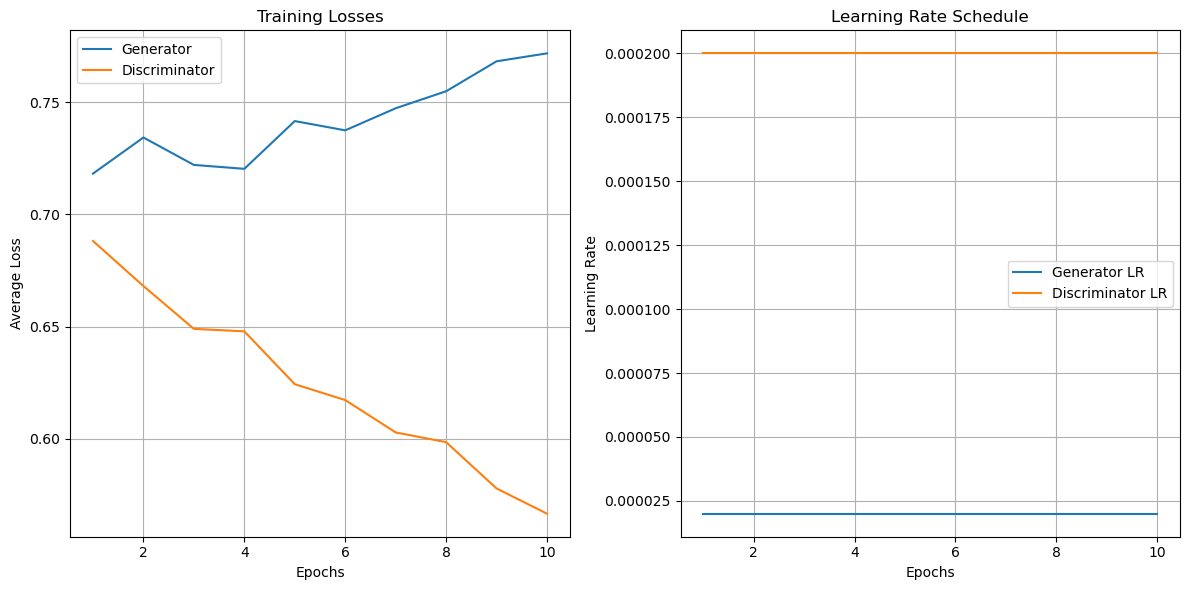

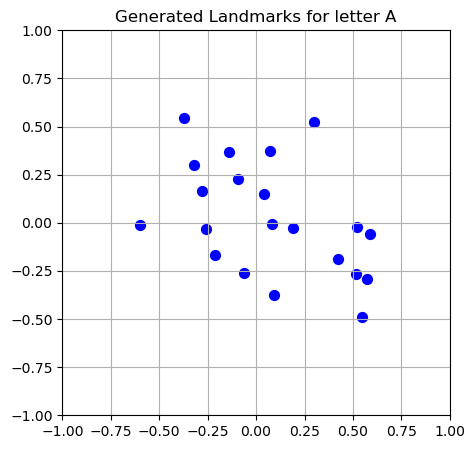

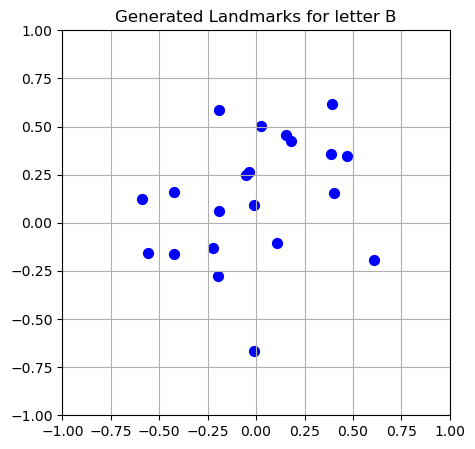

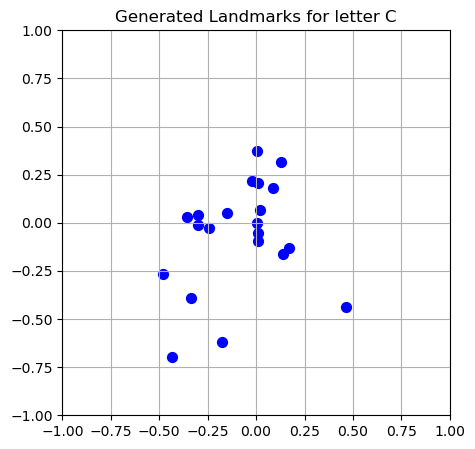

Training Progress:   6%|▌         | 11/200 [00:01<00:31,  6.05it/s]


Epoch 11/200
Generator Loss: 0.7785
Discriminator Loss: 0.5628


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s]



Epoch 12/200
Generator Loss: 0.8101
Discriminator Loss: 0.5450


Training Progress:   6%|▋         | 13/200 [00:01<00:24,  7.55it/s]


Epoch 13/200
Generator Loss: 0.8006
Discriminator Loss: 0.5314


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s]



Epoch 14/200
Generator Loss: 0.8098
Discriminator Loss: 0.5273


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 58.81it/s]



Epoch 15/200
Generator Loss: 0.8224
Discriminator Loss: 0.5005


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 60.49it/s]



Epoch 16/200
Generator Loss: 0.8460
Discriminator Loss: 0.4945


Training Progress:   8%|▊         | 17/200 [00:01<00:15, 12.02it/s]


Epoch 17/200
Generator Loss: 0.8771
Discriminator Loss: 0.4719


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 58.79it/s]



Epoch 18/200
Generator Loss: 0.8887
Discriminator Loss: 0.4627


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s]



Epoch 19/200
Generator Loss: 0.8676
Discriminator Loss: 0.4443


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 66.25it/s]



Epoch 20/200
Generator Loss: 0.8944
Discriminator Loss: 0.4248


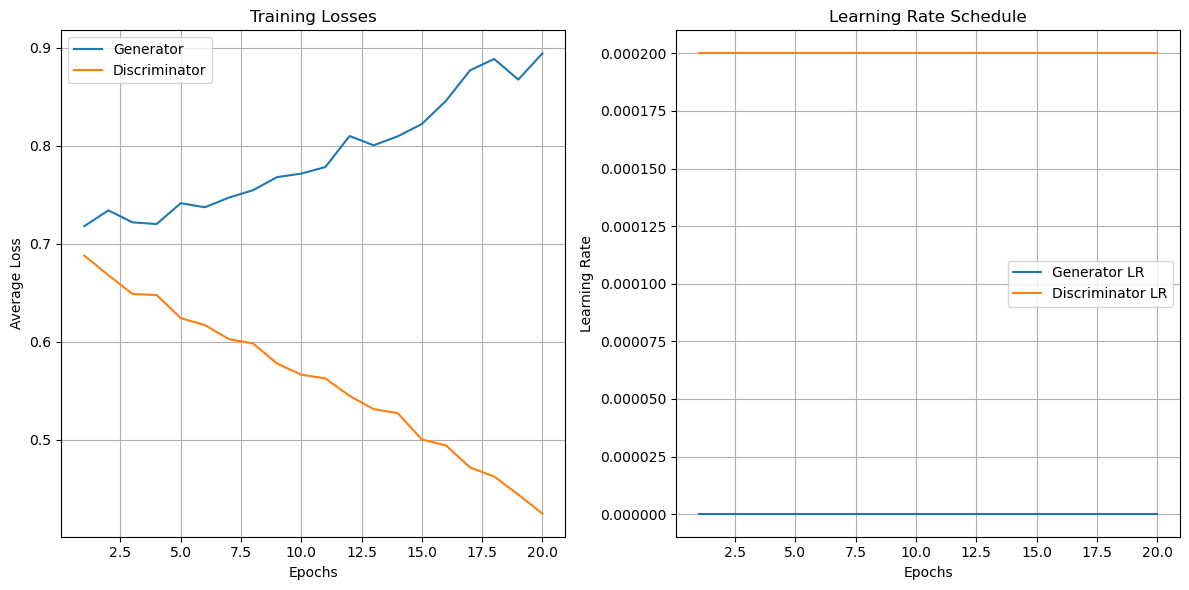

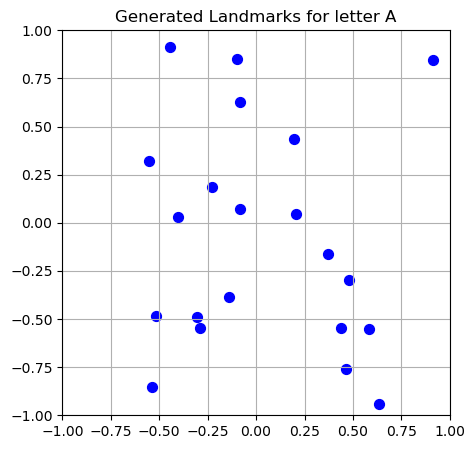

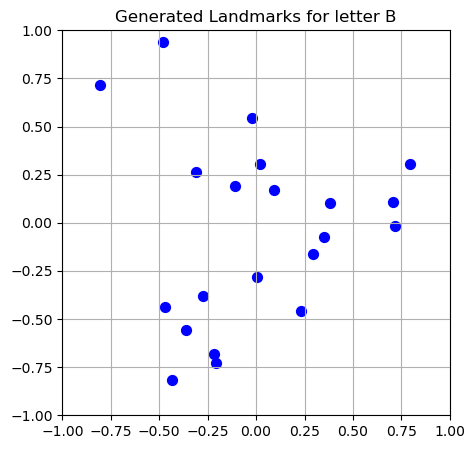

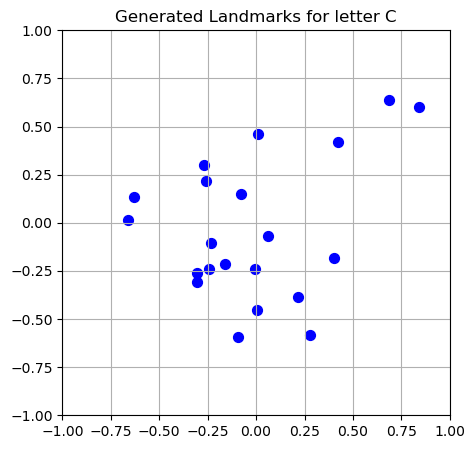

Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 58.20it/s],  6.68it/s]



Epoch 21/200
Generator Loss: 0.9312
Discriminator Loss: 0.4365


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 54.56it/s]



Epoch 22/200
Generator Loss: 0.9862
Discriminator Loss: 0.4050


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s]



Epoch 23/200
Generator Loss: 0.9665
Discriminator Loss: 0.3849


Training Progress:  12%|█▏        | 24/200 [00:02<00:17,  9.82it/s]


Epoch 24/200
Generator Loss: 1.0150
Discriminator Loss: 0.3777


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]



Epoch 25/200
Generator Loss: 1.0211
Discriminator Loss: 0.3545


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 83.27it/s]



Epoch 26/200
Generator Loss: 1.0344
Discriminator Loss: 0.3482


Training Progress:  14%|█▎        | 27/200 [00:02<00:14, 11.70it/s]


Epoch 27/200
Generator Loss: 1.0346
Discriminator Loss: 0.3577


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s]



Epoch 28/200
Generator Loss: 1.0844
Discriminator Loss: 0.3342


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s]



Epoch 29/200
Generator Loss: 1.1483
Discriminator Loss: 0.3243


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 55.38it/s]


Epoch 30/200
Generator Loss: 1.1263
Discriminator Loss: 0.3096


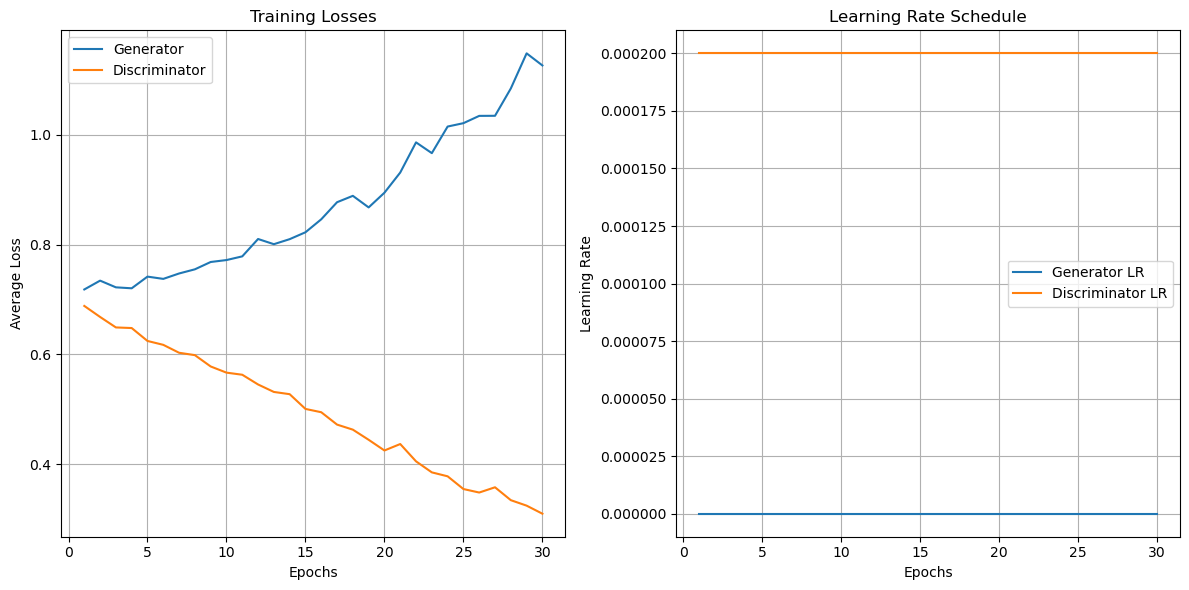

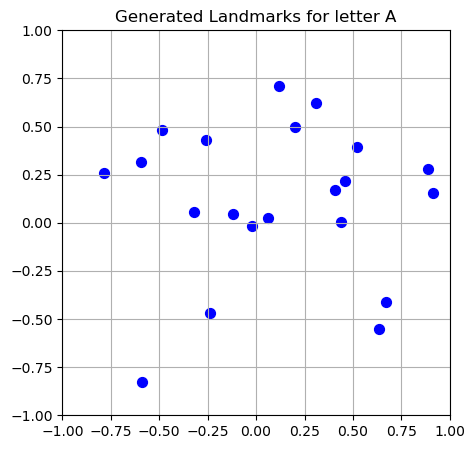

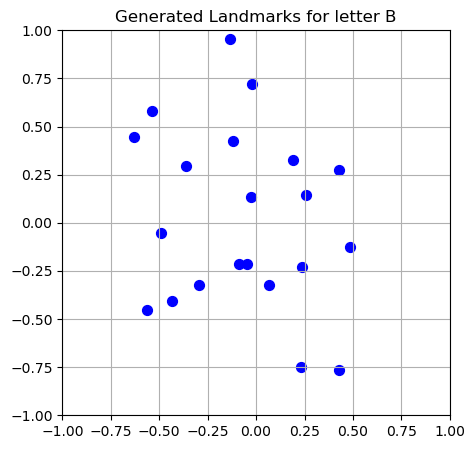

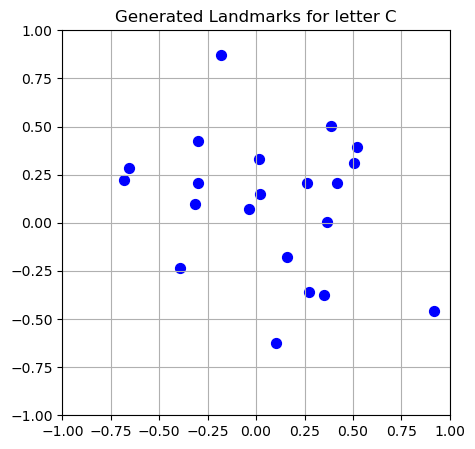

Epoch 30: 100%|██████████| 1/1 [00:00<00:00, 70.96it/s],  5.82it/s]



Epoch 31/200
Generator Loss: 1.1780
Discriminator Loss: 0.2783


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 48.70it/s]



Epoch 32/200
Generator Loss: 1.2068
Discriminator Loss: 0.2794


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s]



Epoch 33/200
Generator Loss: 1.2267
Discriminator Loss: 0.2635


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 47.63it/s]



Epoch 34/200
Generator Loss: 1.3070
Discriminator Loss: 0.2607


Training Progress:  18%|█▊        | 35/200 [00:03<00:19,  8.59it/s]


Epoch 35/200
Generator Loss: 1.3519
Discriminator Loss: 0.2483


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 58.79it/s]



Epoch 36/200
Generator Loss: 1.3195
Discriminator Loss: 0.2526


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s]



Epoch 37/200
Generator Loss: 1.4378
Discriminator Loss: 0.2326


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 49.18it/s]



Epoch 38/200
Generator Loss: 1.3738
Discriminator Loss: 0.2327


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s]



Epoch 39/200
Generator Loss: 1.5386
Discriminator Loss: 0.2150


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s]



Epoch 40/200
Generator Loss: 1.4566
Discriminator Loss: 0.1987


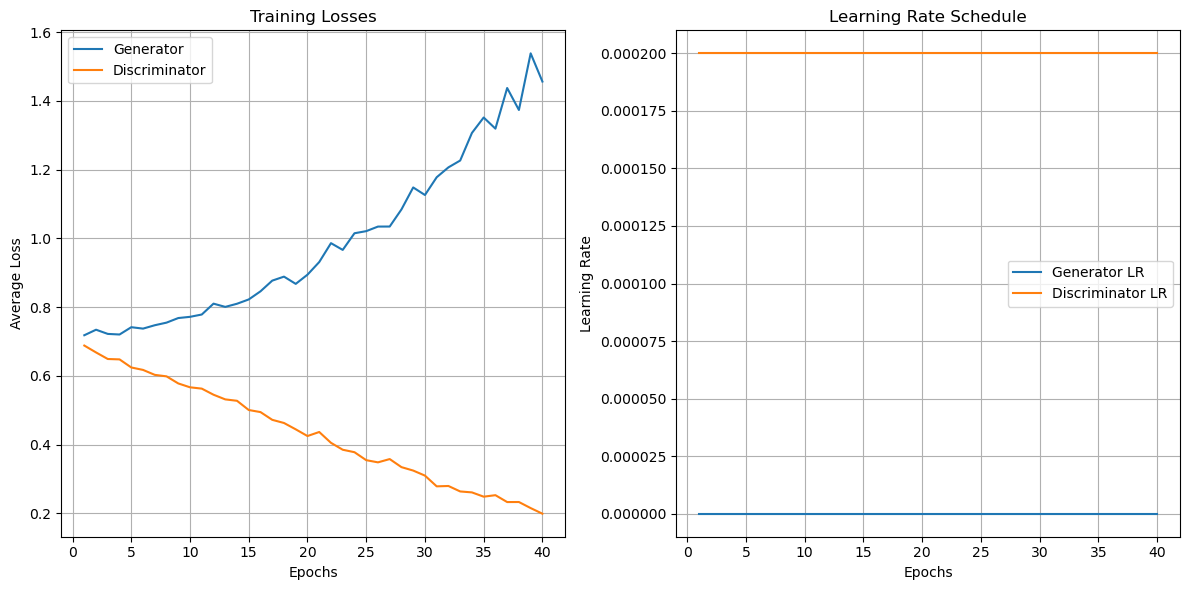

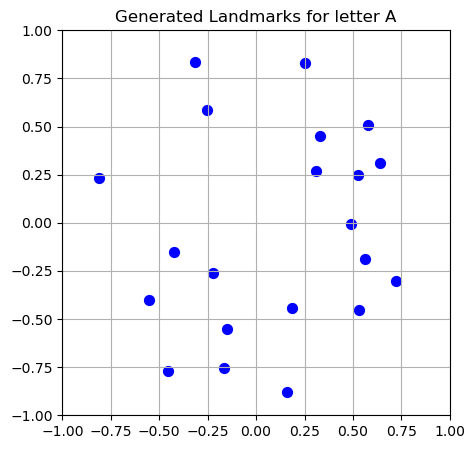

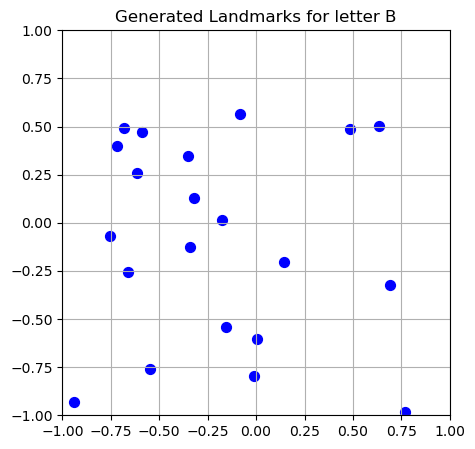

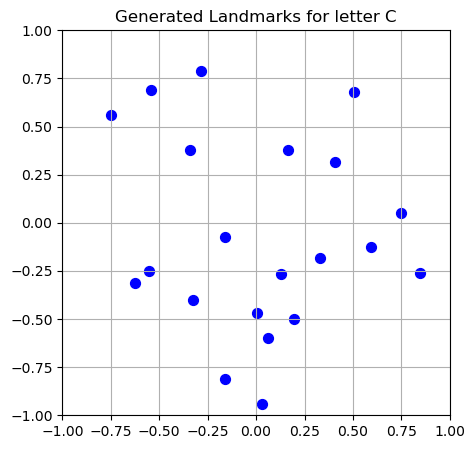

Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 58.84it/s],  7.12it/s]



Epoch 41/200
Generator Loss: 1.5596
Discriminator Loss: 0.1863


Epoch 41: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s]



Epoch 42/200
Generator Loss: 1.6249
Discriminator Loss: 0.1809


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 55.53it/s]



Epoch 43/200
Generator Loss: 1.6394
Discriminator Loss: 0.1618


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s]



Epoch 44/200
Generator Loss: 1.7075
Discriminator Loss: 0.1698


Training Progress:  22%|██▎       | 45/200 [00:05<00:16,  9.51it/s]


Epoch 45/200
Generator Loss: 1.7336
Discriminator Loss: 0.1635


Epoch 45: 100%|██████████| 1/1 [00:00<00:00, 83.31it/s]



Epoch 46/200
Generator Loss: 1.7181
Discriminator Loss: 0.1535


Epoch 46: 100%|██████████| 1/1 [00:00<00:00, 52.54it/s]



Epoch 47/200
Generator Loss: 1.7611
Discriminator Loss: 0.1450


Epoch 47: 100%|██████████| 1/1 [00:00<00:00, 51.22it/s]



Epoch 48/200
Generator Loss: 1.8250
Discriminator Loss: 0.1336


Epoch 48: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s]



Epoch 49/200
Generator Loss: 1.9282
Discriminator Loss: 0.1241


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 25.66it/s]



Epoch 50/200
Generator Loss: 1.8602
Discriminator Loss: 0.1187


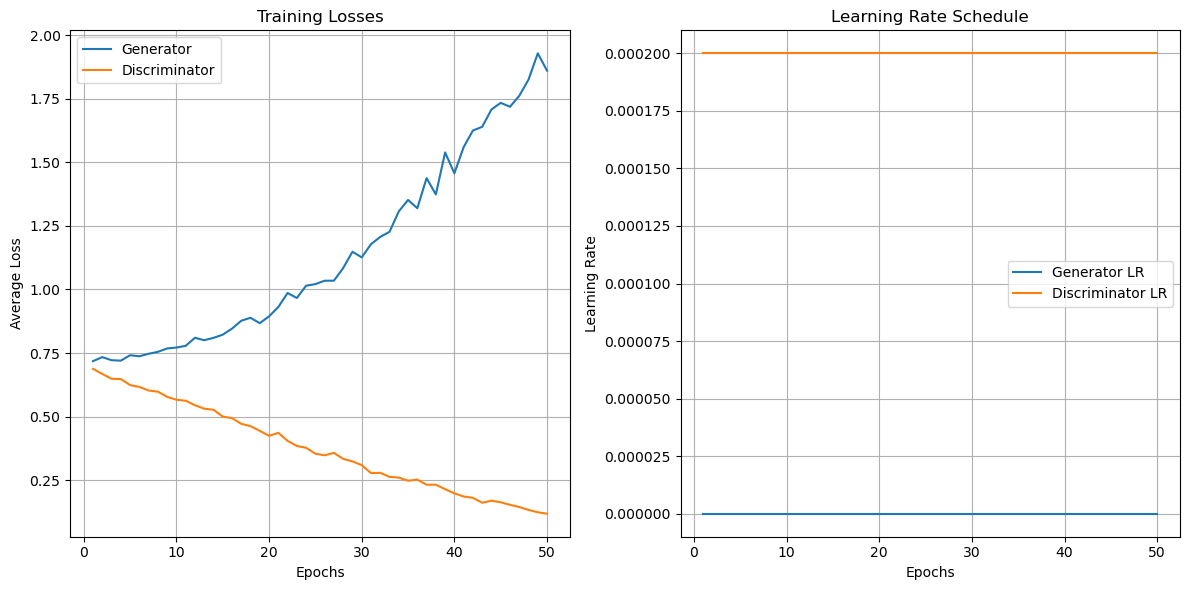

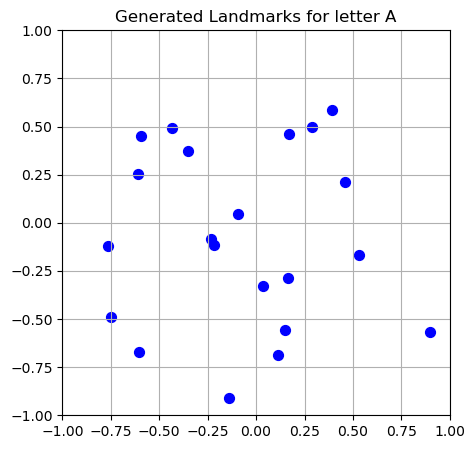

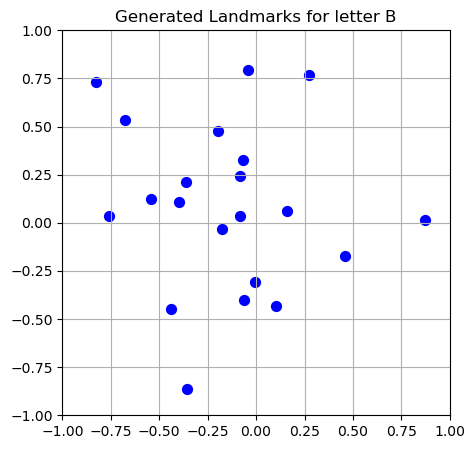

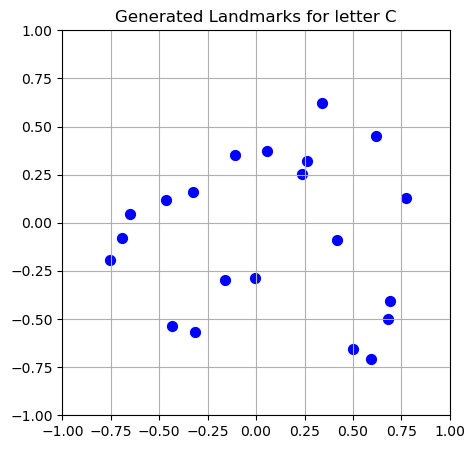

Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s],  7.41it/s]



Epoch 51/200
Generator Loss: 1.9252
Discriminator Loss: 0.1250


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 41.72it/s]



Epoch 52/200
Generator Loss: 2.0314
Discriminator Loss: 0.1176


Epoch 52: 100%|██████████| 1/1 [00:00<00:00, 58.79it/s]



Epoch 53/200
Generator Loss: 1.9761
Discriminator Loss: 0.1128


Epoch 53: 100%|██████████| 1/1 [00:00<00:00, 53.90it/s]



Epoch 54/200
Generator Loss: 2.0749
Discriminator Loss: 0.1186


Training Progress:  28%|██▊       | 55/200 [00:06<00:15,  9.62it/s]


Epoch 55/200
Generator Loss: 2.0886
Discriminator Loss: 0.1146


Epoch 55: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s]



Epoch 56/200
Generator Loss: 2.1691
Discriminator Loss: 0.0912


Epoch 56: 100%|██████████| 1/1 [00:00<00:00, 41.66it/s]



Epoch 57/200
Generator Loss: 2.2245
Discriminator Loss: 0.0930


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 52.59it/s]



Epoch 58/200
Generator Loss: 2.2253
Discriminator Loss: 0.0936


Training Progress:  30%|██▉       | 59/200 [00:06<00:11, 12.00it/s]


Epoch 59/200
Generator Loss: 2.3602
Discriminator Loss: 0.0978


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 57.34it/s]



Epoch 60/200
Generator Loss: 2.2527
Discriminator Loss: 0.0907


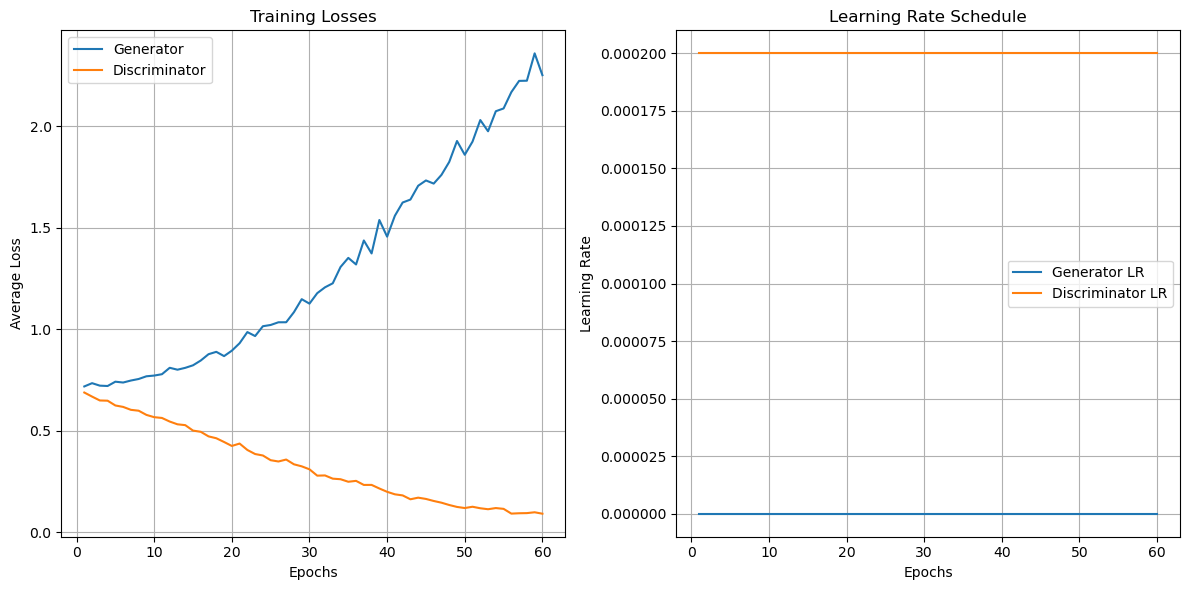

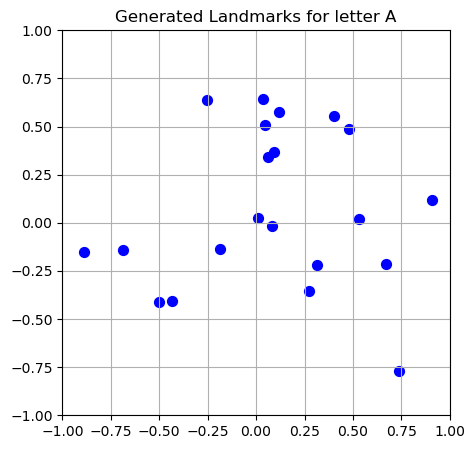

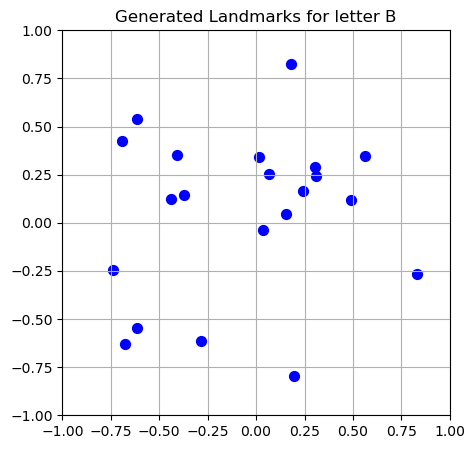

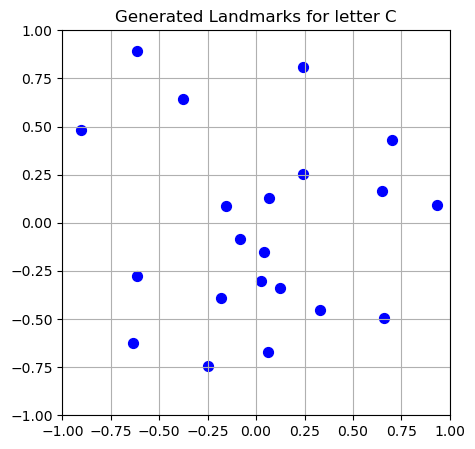

Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 36.84it/s]



Epoch 61/200
Generator Loss: 2.3288
Discriminator Loss: 0.0839


Training Progress:  31%|███       | 62/200 [00:07<00:18,  7.47it/s]


Epoch 62/200
Generator Loss: 2.4983
Discriminator Loss: 0.0805


Epoch 62: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]



Epoch 63/200
Generator Loss: 2.3555
Discriminator Loss: 0.0876


Training Progress:  32%|███▏      | 64/200 [00:07<00:16,  8.01it/s]


Epoch 64/200
Generator Loss: 2.4001
Discriminator Loss: 0.0937


Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 47.59it/s]



Epoch 65/200
Generator Loss: 2.4734
Discriminator Loss: 0.0760


Training Progress:  33%|███▎      | 66/200 [00:07<00:14,  9.07it/s]


Epoch 66/200
Generator Loss: 2.5139
Discriminator Loss: 0.0744


Epoch 66: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]



Epoch 67/200
Generator Loss: 2.5359
Discriminator Loss: 0.0715


Training Progress:  34%|███▍      | 68/200 [00:07<00:14,  9.24it/s]


Epoch 68/200
Generator Loss: 2.5671
Discriminator Loss: 0.0642


Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 30.92it/s]



Epoch 69/200
Generator Loss: 2.6990
Discriminator Loss: 0.0672


Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 41.29it/s]


Epoch 70/200
Generator Loss: 2.6807
Discriminator Loss: 0.0620


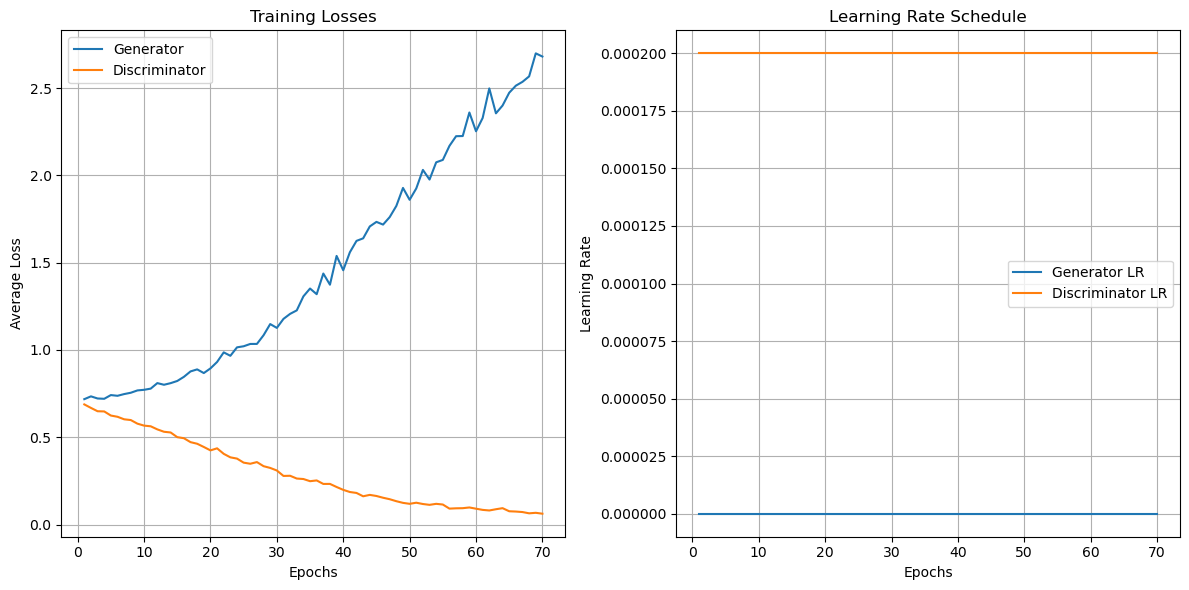

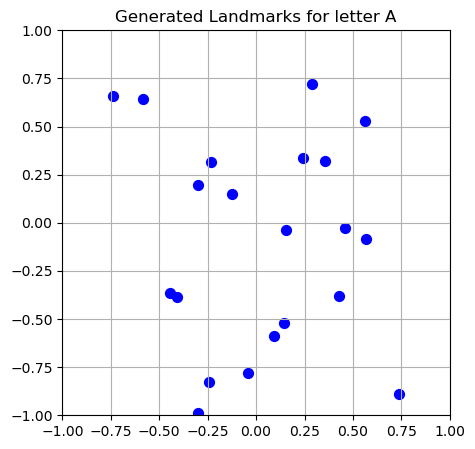

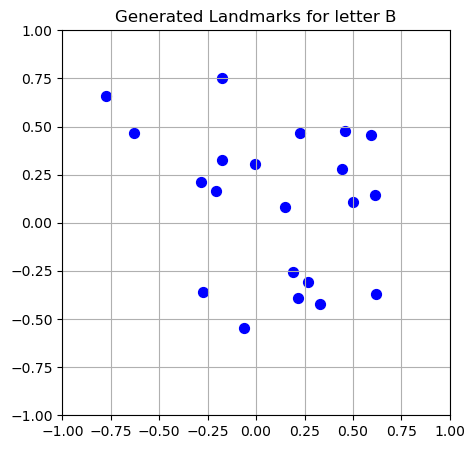

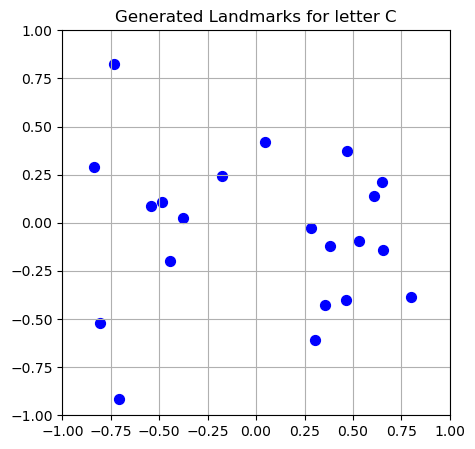

Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 60.15it/s],  5.08it/s]



Epoch 71/200
Generator Loss: 2.6737
Discriminator Loss: 0.0673


Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 40.79it/s]



Epoch 72/200
Generator Loss: 2.7466
Discriminator Loss: 0.0568


Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s]



Epoch 73/200
Generator Loss: 2.7401
Discriminator Loss: 0.0575


Training Progress:  37%|███▋      | 74/200 [00:08<00:16,  7.85it/s]


Epoch 74/200
Generator Loss: 2.8511
Discriminator Loss: 0.0517


Epoch 74: 100%|██████████| 1/1 [00:00<00:00, 40.70it/s]



Epoch 75/200
Generator Loss: 2.7995
Discriminator Loss: 0.0492


Training Progress:  38%|███▊      | 76/200 [00:08<00:14,  8.83it/s]


Epoch 76/200
Generator Loss: 3.1242
Discriminator Loss: 0.0557


Epoch 76: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s]



Epoch 77/200
Generator Loss: 2.8131
Discriminator Loss: 0.0546


Epoch 77: 100%|██████████| 1/1 [00:00<00:00, 44.70it/s]



Epoch 78/200
Generator Loss: 2.8966
Discriminator Loss: 0.0544


Epoch 78: 100%|██████████| 1/1 [00:00<00:00, 32.77it/s]



Epoch 79/200
Generator Loss: 3.0155
Discriminator Loss: 0.0553


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 35.72it/s]



Epoch 80/200
Generator Loss: 2.9376
Discriminator Loss: 0.0431


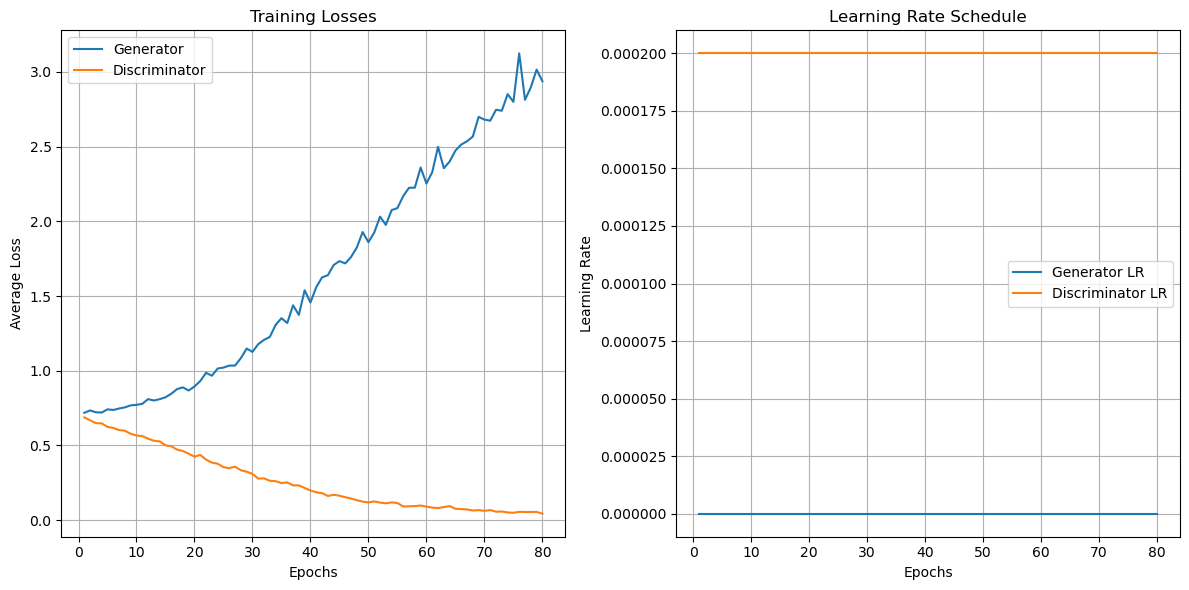

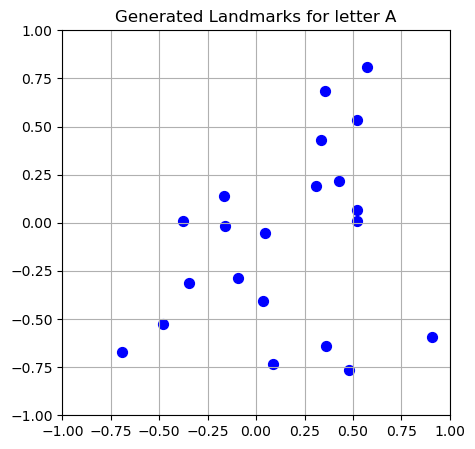

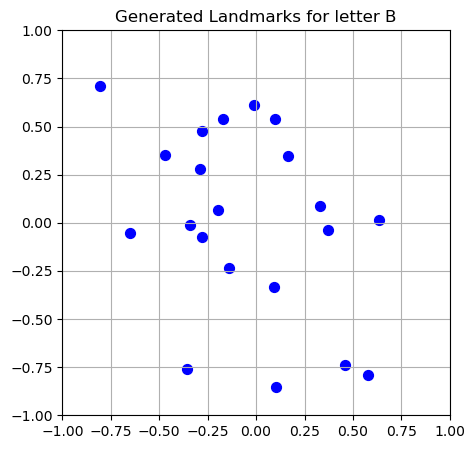

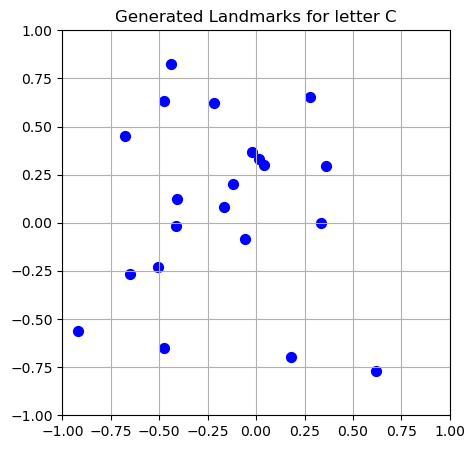

Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 58.79it/s],  6.13it/s]



Epoch 81/200
Generator Loss: 3.1221
Discriminator Loss: 0.0498


Epoch 81: 100%|██████████| 1/1 [00:00<00:00, 57.07it/s]



Epoch 82/200
Generator Loss: 3.1276
Discriminator Loss: 0.0467


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s]



Epoch 83/200
Generator Loss: 3.2105
Discriminator Loss: 0.0404


Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s]



Epoch 84/200
Generator Loss: 3.0283
Discriminator Loss: 0.0400


Training Progress:  42%|████▎     | 85/200 [00:10<00:12,  8.90it/s]


Epoch 85/200
Generator Loss: 3.2015
Discriminator Loss: 0.0332


Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s]



Epoch 86/200
Generator Loss: 3.1735
Discriminator Loss: 0.0430


Epoch 86: 100%|██████████| 1/1 [00:00<00:00, 54.09it/s]



Epoch 87/200
Generator Loss: 3.2013
Discriminator Loss: 0.0407


Epoch 87: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s]



Epoch 88/200
Generator Loss: 3.4009
Discriminator Loss: 0.0412


Training Progress:  44%|████▍     | 89/200 [00:10<00:09, 11.84it/s]


Epoch 89/200
Generator Loss: 3.2363
Discriminator Loss: 0.0409


Epoch 89: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s]



Epoch 90/200
Generator Loss: 3.2346
Discriminator Loss: 0.0337


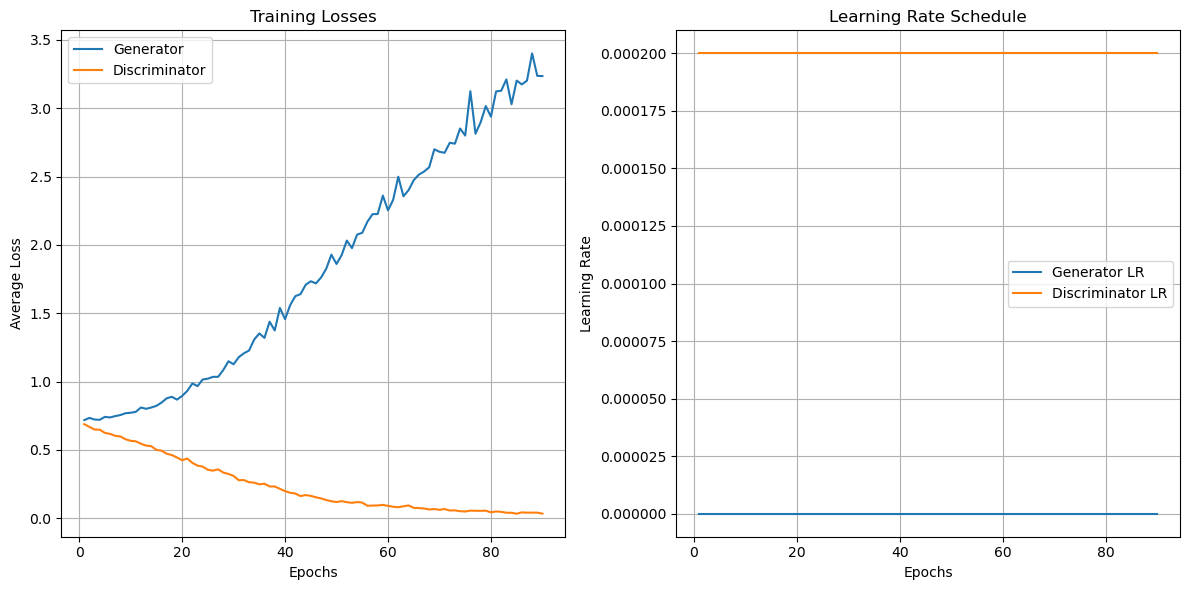

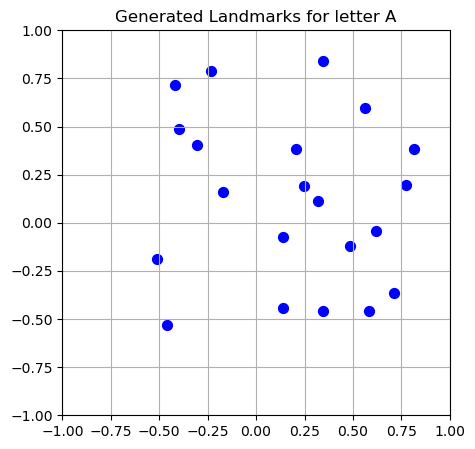

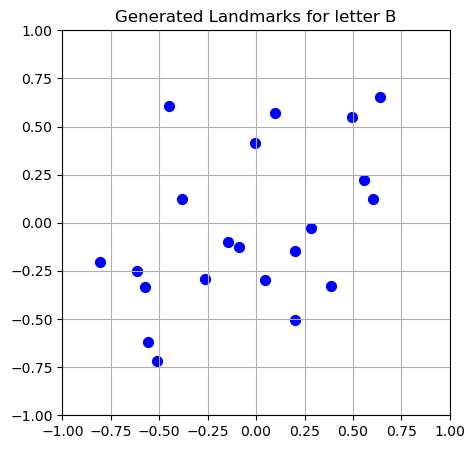

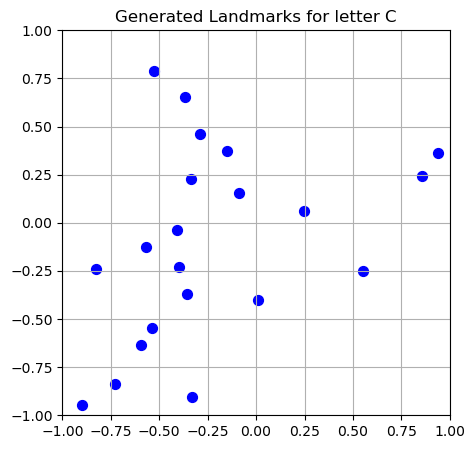

Epoch 90: 100%|██████████| 1/1 [00:00<00:00, 29.15it/s]



Epoch 91/200
Generator Loss: 3.4094
Discriminator Loss: 0.0312


Training Progress:  46%|████▌     | 92/200 [00:11<00:16,  6.70it/s]


Epoch 92/200
Generator Loss: 3.3577
Discriminator Loss: 0.0275


Epoch 92: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]



Epoch 93/200
Generator Loss: 3.3574
Discriminator Loss: 0.0287


Training Progress:  47%|████▋     | 94/200 [00:11<00:14,  7.54it/s]


Epoch 94/200
Generator Loss: 3.4479
Discriminator Loss: 0.0302


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s]



Epoch 95/200
Generator Loss: 3.5738
Discriminator Loss: 0.0358


Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 55.54it/s]



Epoch 96/200
Generator Loss: 3.3499
Discriminator Loss: 0.0322


Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 45.42it/s]



Epoch 97/200
Generator Loss: 3.5292
Discriminator Loss: 0.0342


Training Progress:  49%|████▉     | 98/200 [00:11<00:09, 10.60it/s]


Epoch 98/200
Generator Loss: 3.5848
Discriminator Loss: 0.0268


Epoch 98: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s]



Epoch 99/200
Generator Loss: 3.4919
Discriminator Loss: 0.0337


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 41.00it/s]



Epoch 100/200
Generator Loss: 3.5762
Discriminator Loss: 0.0249


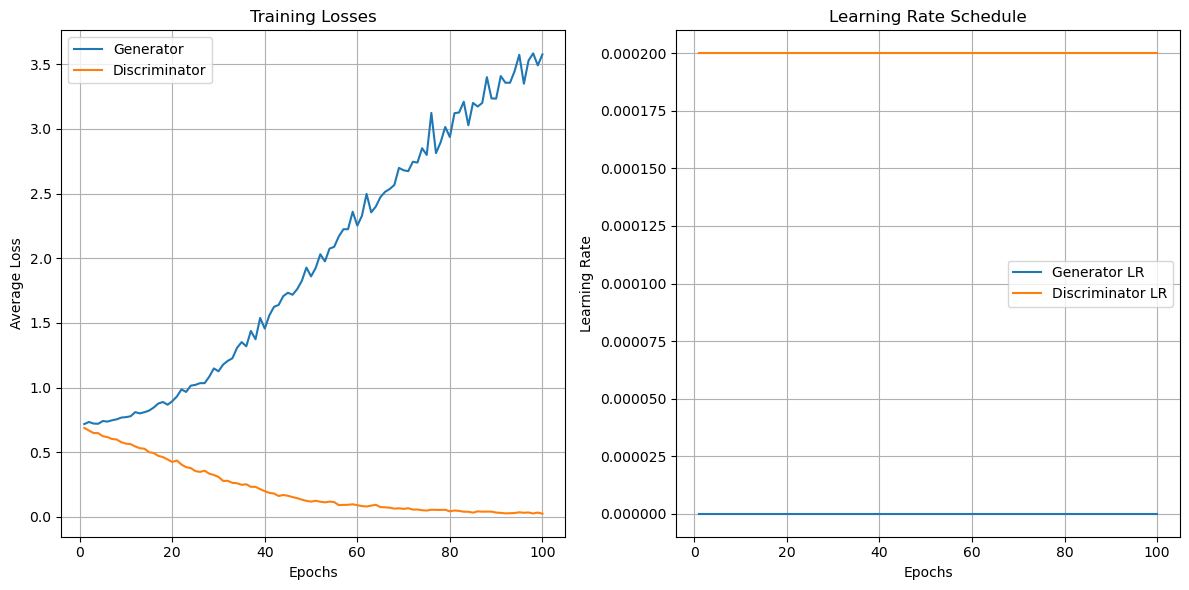

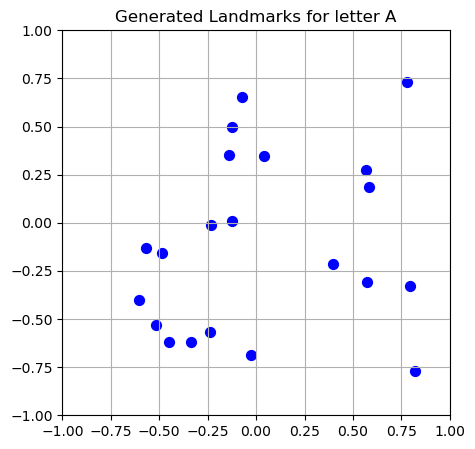

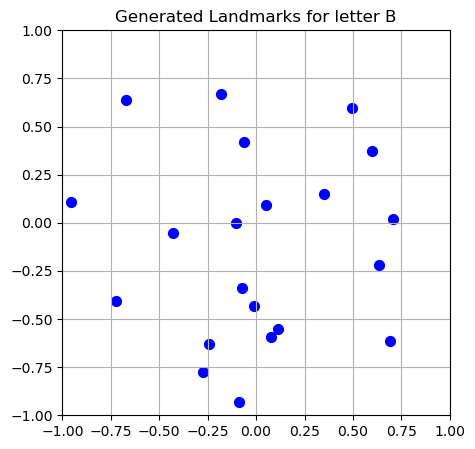

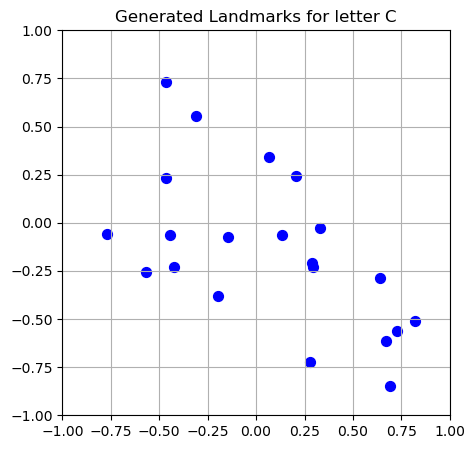

Training Progress:  50%|█████     | 101/200 [00:12<00:18,  5.38it/s]


Epoch 101/200
Generator Loss: 3.6176
Discriminator Loss: 0.0265


Epoch 101: 100%|██████████| 1/1 [00:00<00:00, 52.21it/s]



Epoch 102/200
Generator Loss: 3.5165
Discriminator Loss: 0.0284


Epoch 102: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s]



Epoch 103/200
Generator Loss: 3.5670
Discriminator Loss: 0.0249


Training Progress:  52%|█████▏    | 104/200 [00:12<00:14,  6.85it/s]


Epoch 104/200
Generator Loss: 3.5238
Discriminator Loss: 0.0250


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 34.47it/s]



Epoch 105/200
Generator Loss: 3.6321
Discriminator Loss: 0.0217


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 27.77it/s]



Epoch 106/200
Generator Loss: 3.7689
Discriminator Loss: 0.0227


Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 53.99it/s]



Epoch 107/200
Generator Loss: 3.6936
Discriminator Loss: 0.0229


Training Progress:  54%|█████▍    | 108/200 [00:12<00:09,  9.46it/s]


Epoch 108/200
Generator Loss: 3.8338
Discriminator Loss: 0.0250


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s]



Epoch 109/200
Generator Loss: 3.9132
Discriminator Loss: 0.0199


Epoch 109: 100%|██████████| 1/1 [00:00<00:00, 62.47it/s]



Epoch 110/200
Generator Loss: 3.8510
Discriminator Loss: 0.0248


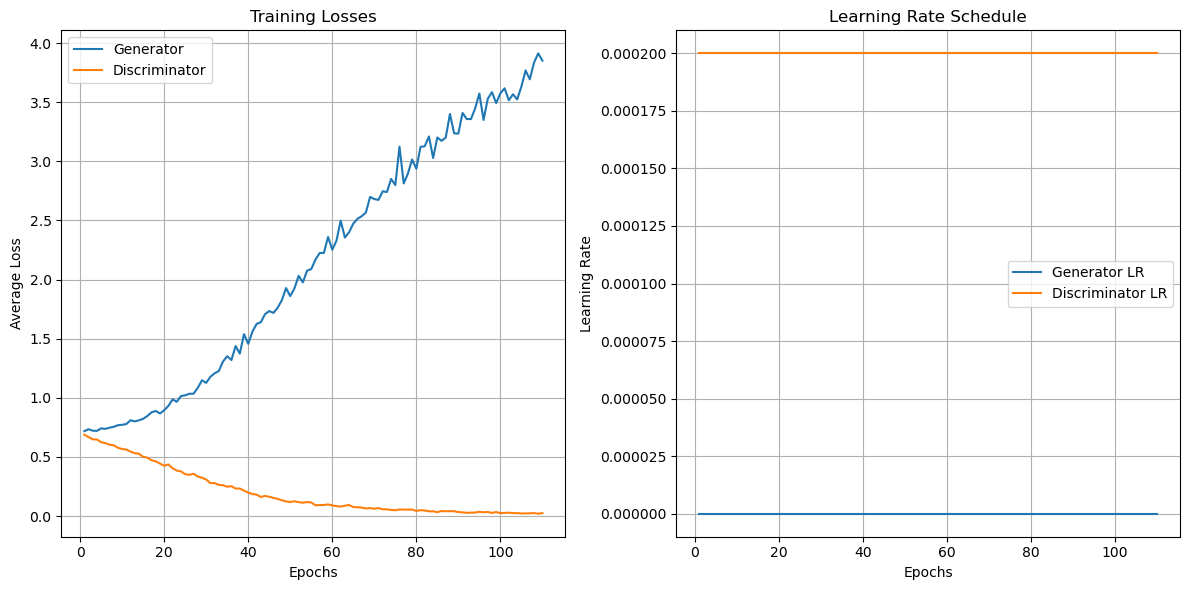

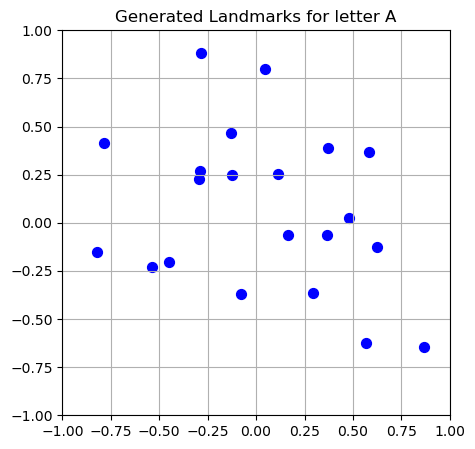

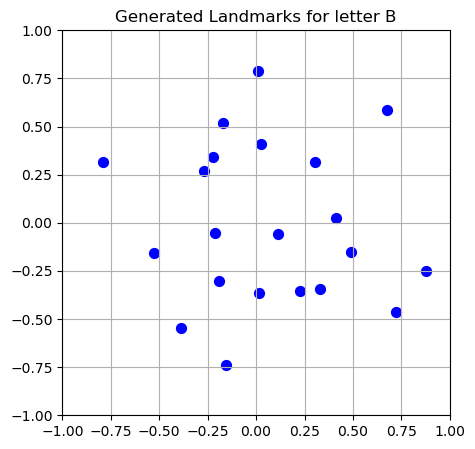

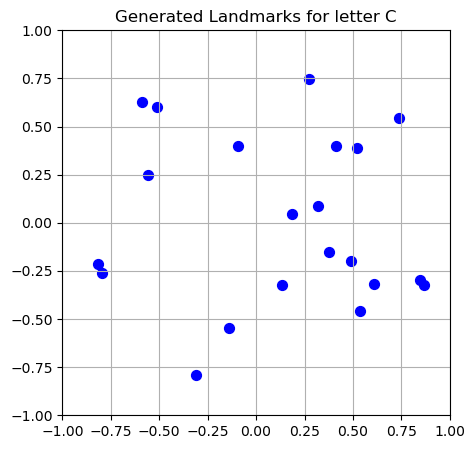

Training Progress:  56%|█████▌    | 111/200 [00:13<00:14,  6.01it/s]


Epoch 111/200
Generator Loss: 3.7966
Discriminator Loss: 0.0203


Epoch 111: 100%|██████████| 1/1 [00:00<00:00, 48.82it/s]



Epoch 112/200
Generator Loss: 3.8711
Discriminator Loss: 0.0222


Training Progress:  56%|█████▋    | 113/200 [00:14<00:12,  6.93it/s]


Epoch 113/200
Generator Loss: 3.9907
Discriminator Loss: 0.0211


Epoch 113: 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]



Epoch 114/200
Generator Loss: 4.0617
Discriminator Loss: 0.0171


Epoch 114: 100%|██████████| 1/1 [00:00<00:00, 43.38it/s]



Epoch 115/200
Generator Loss: 3.9326
Discriminator Loss: 0.0214


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 45.44it/s]



Epoch 116/200
Generator Loss: 4.0390
Discriminator Loss: 0.0212


Training Progress:  58%|█████▊    | 117/200 [00:14<00:08,  9.83it/s]


Epoch 117/200
Generator Loss: 4.0921
Discriminator Loss: 0.0206


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 47.60it/s]



Epoch 118/200
Generator Loss: 3.9816
Discriminator Loss: 0.0221


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 54.01it/s]



Epoch 119/200
Generator Loss: 3.9033
Discriminator Loss: 0.0247


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s]



Epoch 120/200
Generator Loss: 4.0606
Discriminator Loss: 0.0346


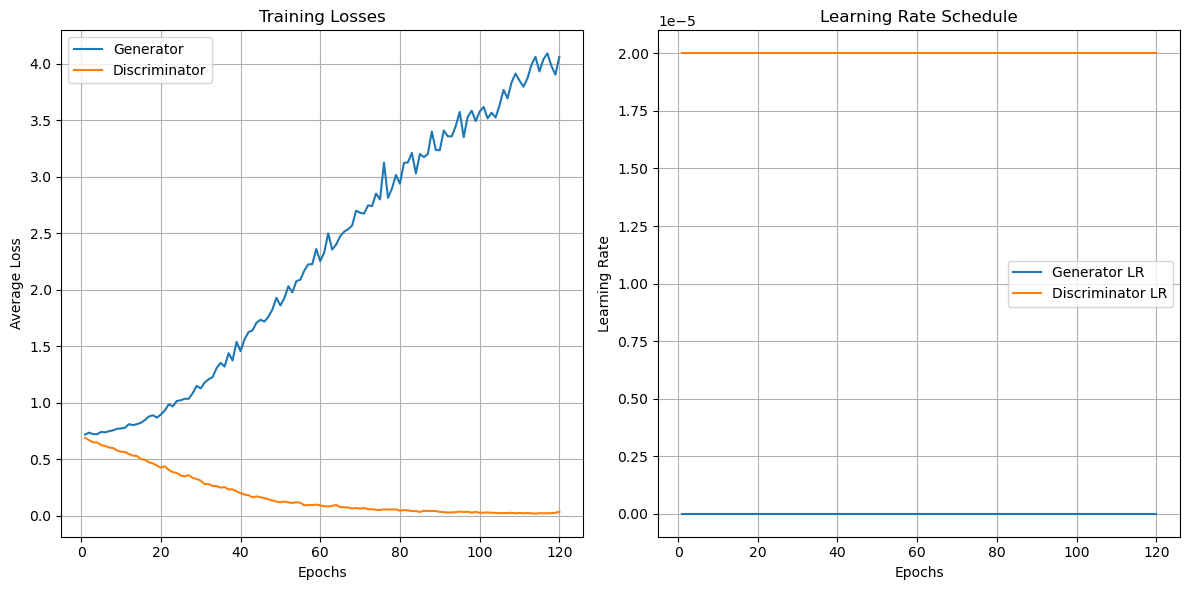

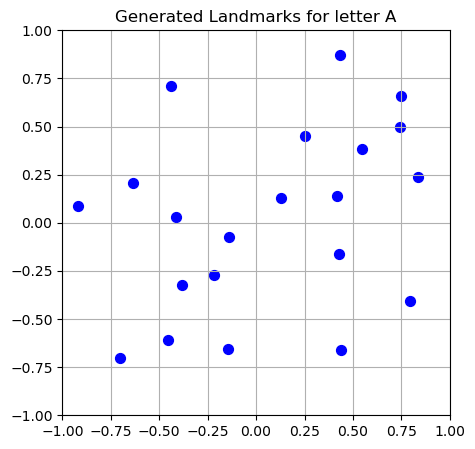

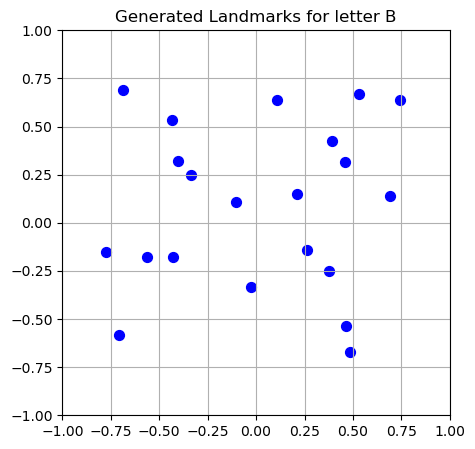

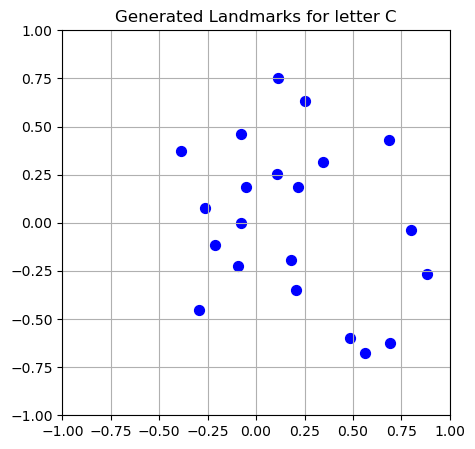

Epoch 120: 100%|██████████| 1/1 [00:00<00:00, 46.47it/s],  5.89it/s]



Epoch 121/200
Generator Loss: 4.0906
Discriminator Loss: 0.0164


Epoch 121: 100%|██████████| 1/1 [00:00<00:00, 47.61it/s]



Epoch 122/200
Generator Loss: 4.2917
Discriminator Loss: 0.0141


Epoch 122: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s]



Epoch 123/200
Generator Loss: 4.0260
Discriminator Loss: 0.0124


Training Progress:  62%|██████▏   | 124/200 [00:15<00:09,  8.35it/s]


Epoch 124/200
Generator Loss: 4.0234
Discriminator Loss: 0.0153


Epoch 124: 100%|██████████| 1/1 [00:00<00:00, 40.78it/s]



Epoch 125/200
Generator Loss: 4.0877
Discriminator Loss: 0.0164


Epoch 125: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s]



Epoch 126/200
Generator Loss: 4.0119
Discriminator Loss: 0.0384


Epoch 126: 100%|██████████| 1/1 [00:00<00:00, 48.96it/s]



Epoch 127/200
Generator Loss: 4.3372
Discriminator Loss: 0.0139


Training Progress:  64%|██████▍   | 128/200 [00:15<00:06, 11.23it/s]


Epoch 128/200
Generator Loss: 4.1482
Discriminator Loss: 0.0167


Epoch 128: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]



Epoch 129/200
Generator Loss: 3.9314
Discriminator Loss: 0.0143


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]



Epoch 130/200
Generator Loss: 4.1403
Discriminator Loss: 0.0175


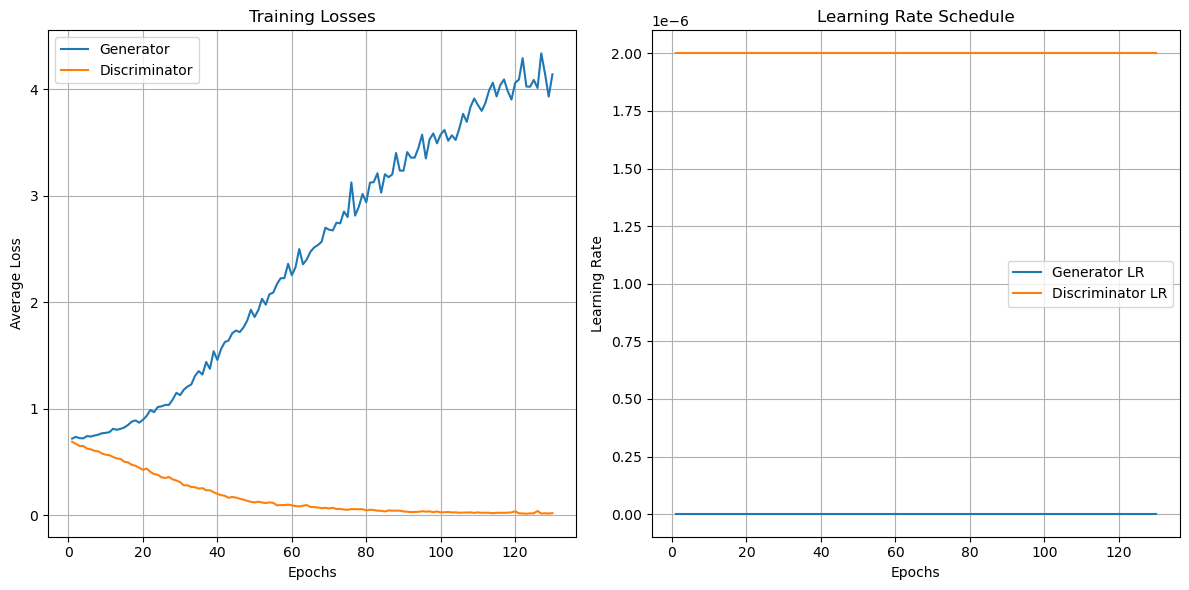

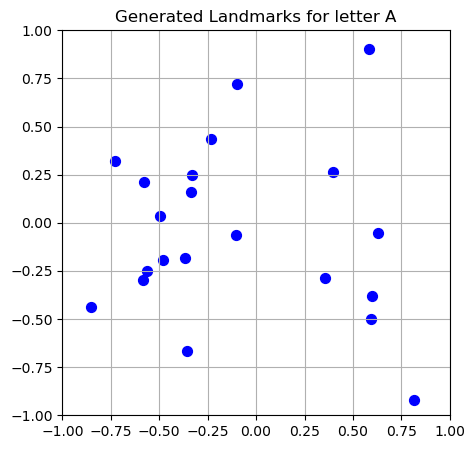

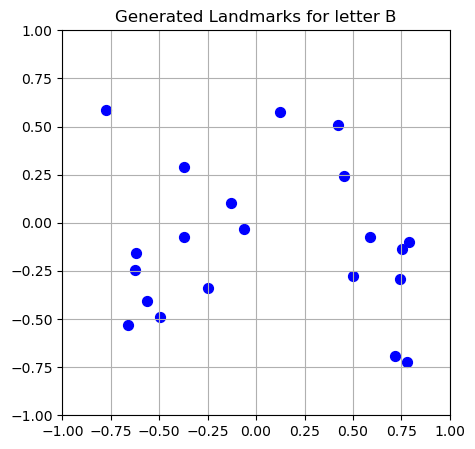

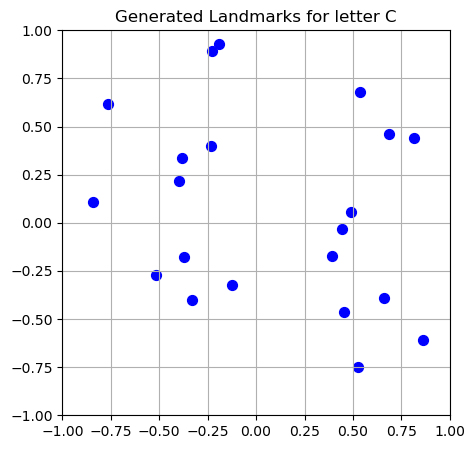

Training Progress:  66%|██████▌   | 131/200 [00:16<00:11,  6.14it/s]


Epoch 131/200
Generator Loss: 4.1590
Discriminator Loss: 0.0197


Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 43.47it/s]



Epoch 132/200
Generator Loss: 4.1429
Discriminator Loss: 0.0225


Epoch 132: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s]



Epoch 133/200
Generator Loss: 4.1305
Discriminator Loss: 0.0160


Epoch 133: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s]



Epoch 134/200
Generator Loss: 4.1177
Discriminator Loss: 0.0168


Training Progress:  68%|██████▊   | 135/200 [00:16<00:07,  8.50it/s]


Epoch 135/200
Generator Loss: 4.0745
Discriminator Loss: 0.0156


Epoch 135: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s]



Epoch 136/200
Generator Loss: 3.9697
Discriminator Loss: 0.0160


Epoch 136: 100%|██████████| 1/1 [00:00<00:00, 30.29it/s]



Epoch 137/200
Generator Loss: 4.0409
Discriminator Loss: 0.0206


Training Progress:  69%|██████▉   | 138/200 [00:16<00:06,  9.87it/s]


Epoch 138/200
Generator Loss: 4.1121
Discriminator Loss: 0.0209


Epoch 138: 100%|██████████| 1/1 [00:00<00:00, 36.34it/s]



Epoch 139/200
Generator Loss: 3.9395
Discriminator Loss: 0.0165


Epoch 139: 100%|██████████| 1/1 [00:00<00:00, 47.73it/s]



Epoch 140/200
Generator Loss: 4.1757
Discriminator Loss: 0.0177


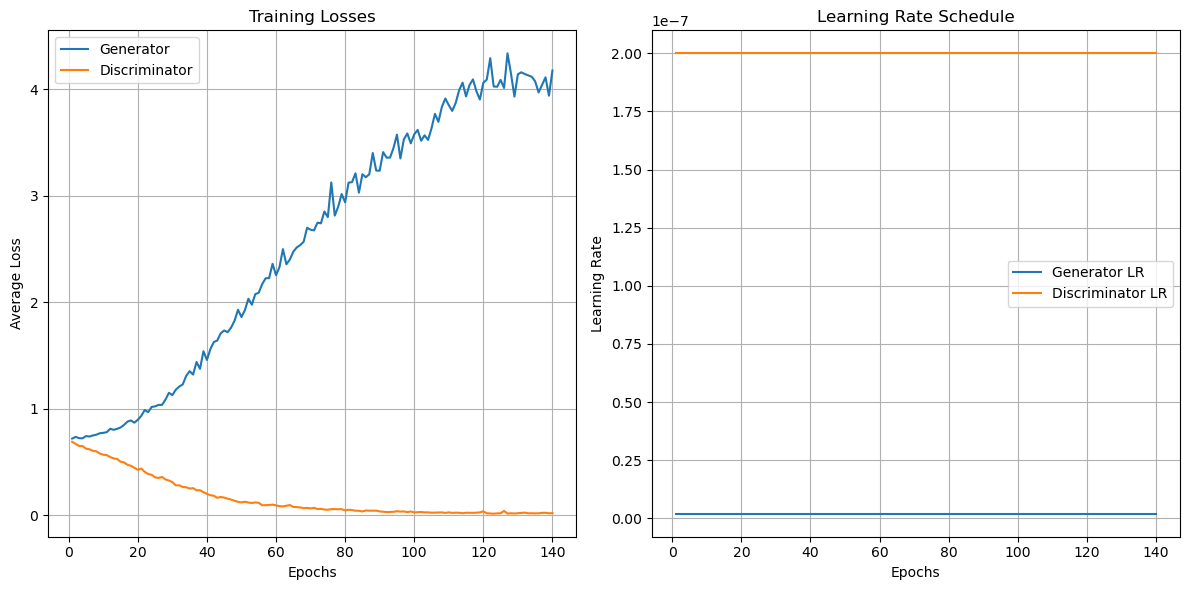

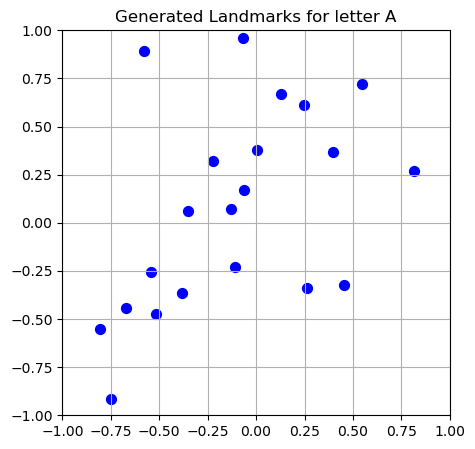

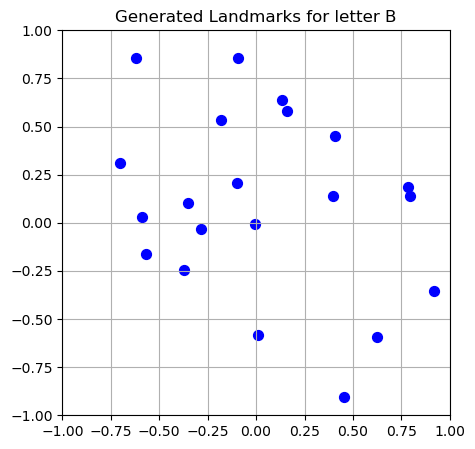

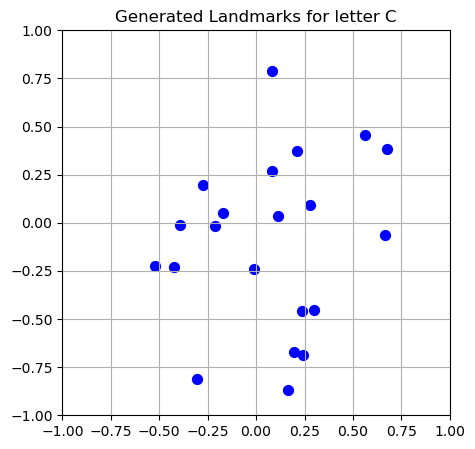

Training Progress:  70%|███████   | 141/200 [00:17<00:09,  6.27it/s]


Epoch 141/200
Generator Loss: 4.2718
Discriminator Loss: 0.0150


Epoch 141: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]



Epoch 142/200
Generator Loss: 4.1219
Discriminator Loss: 0.0189


Training Progress:  72%|███████▏  | 143/200 [00:17<00:08,  6.97it/s]


Epoch 143/200
Generator Loss: 4.0043
Discriminator Loss: 0.0192


Epoch 143: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]



Epoch 144/200
Generator Loss: 3.8881
Discriminator Loss: 0.0200


Training Progress:  72%|███████▎  | 145/200 [00:18<00:07,  7.45it/s]


Epoch 145/200
Generator Loss: 3.8482
Discriminator Loss: 0.0186


Epoch 145: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]



Epoch 146/200
Generator Loss: 4.2312
Discriminator Loss: 0.0173


Training Progress:  74%|███████▎  | 147/200 [00:18<00:06,  8.36it/s]


Epoch 147/200
Generator Loss: 3.9819
Discriminator Loss: 0.0211


Epoch 147: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s]



Epoch 148/200
Generator Loss: 4.1320
Discriminator Loss: 0.0175


Epoch 148: 100%|██████████| 1/1 [00:00<00:00, 46.47it/s]



Epoch 149/200
Generator Loss: 4.0963
Discriminator Loss: 0.0171


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 55.54it/s]



Epoch 150/200
Generator Loss: 4.0194
Discriminator Loss: 0.0146


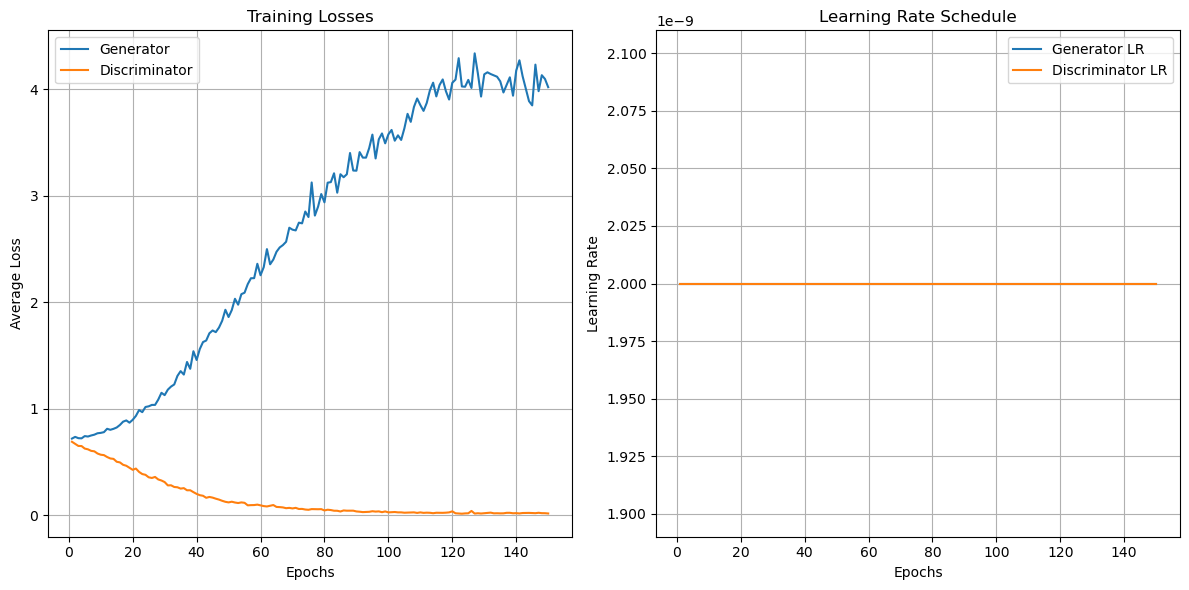

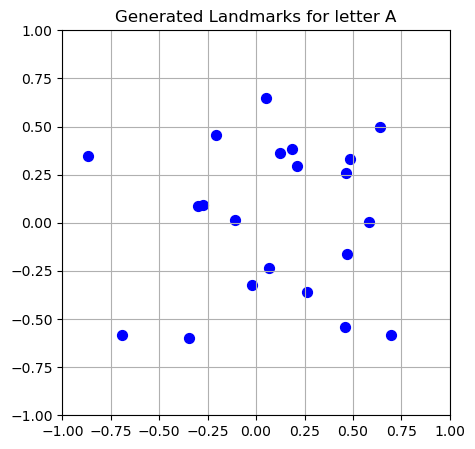

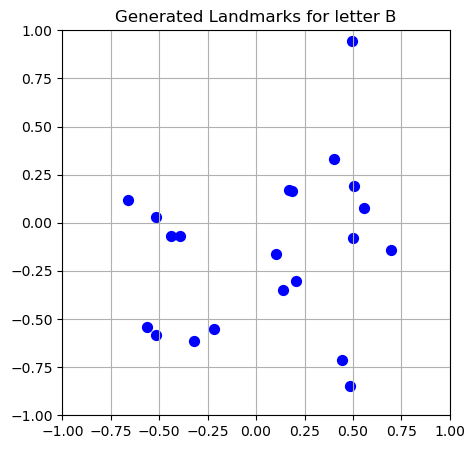

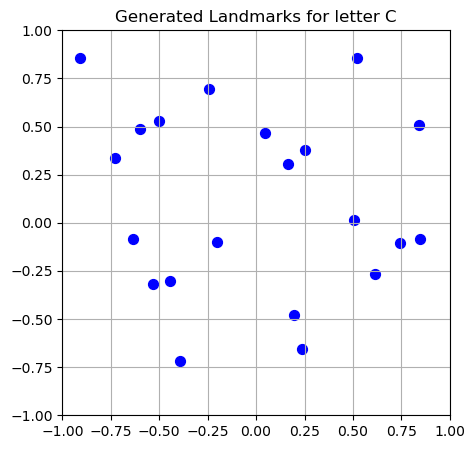

Epoch 150: 100%|██████████| 1/1 [00:00<00:00, 62.27it/s],  5.45it/s]



Epoch 151/200
Generator Loss: 4.1770
Discriminator Loss: 0.0159


Epoch 151: 100%|██████████| 1/1 [00:00<00:00, 46.47it/s]



Epoch 152/200
Generator Loss: 4.0496
Discriminator Loss: 0.0239


Epoch 152: 100%|██████████| 1/1 [00:00<00:00, 62.50it/s]



Epoch 153/200
Generator Loss: 4.2569
Discriminator Loss: 0.0164


Training Progress:  77%|███████▋  | 154/200 [00:19<00:05,  8.29it/s]


Epoch 154/200
Generator Loss: 4.1187
Discriminator Loss: 0.0159


Epoch 154: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]



Epoch 155/200
Generator Loss: 4.0344
Discriminator Loss: 0.0144


Training Progress:  78%|███████▊  | 156/200 [00:19<00:04,  9.38it/s]


Epoch 156/200
Generator Loss: 3.8876
Discriminator Loss: 0.0215


Epoch 156: 100%|██████████| 1/1 [00:00<00:00, 37.70it/s]



Epoch 157/200
Generator Loss: 4.2385
Discriminator Loss: 0.0165


Epoch 157: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s]



Epoch 158/200
Generator Loss: 4.0742
Discriminator Loss: 0.0214


Epoch 158: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s]



Epoch 159/200
Generator Loss: 4.0023
Discriminator Loss: 0.0242


Epoch 159: 100%|██████████| 1/1 [00:00<00:00, 49.96it/s]



Epoch 160/200
Generator Loss: 4.0799
Discriminator Loss: 0.0168


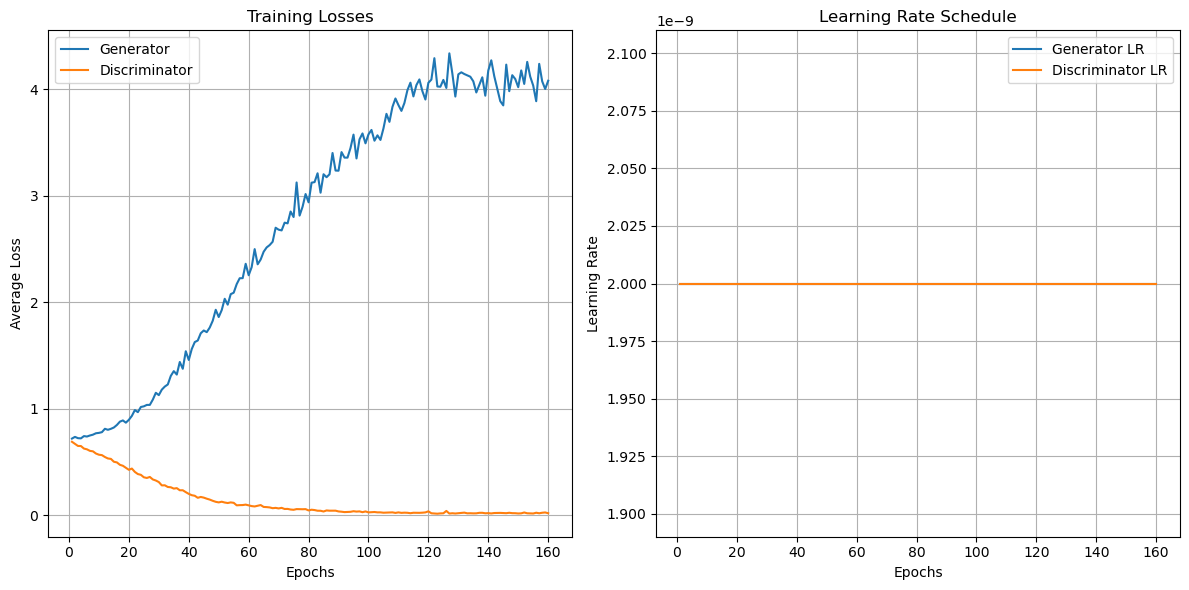

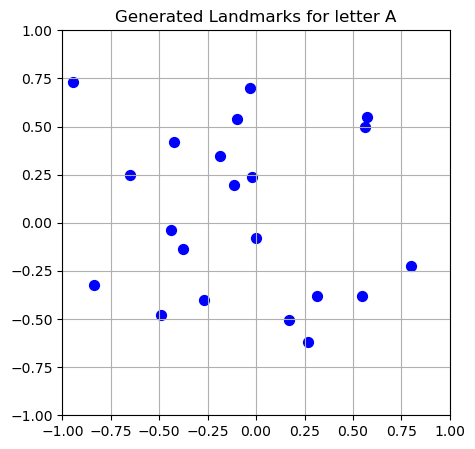

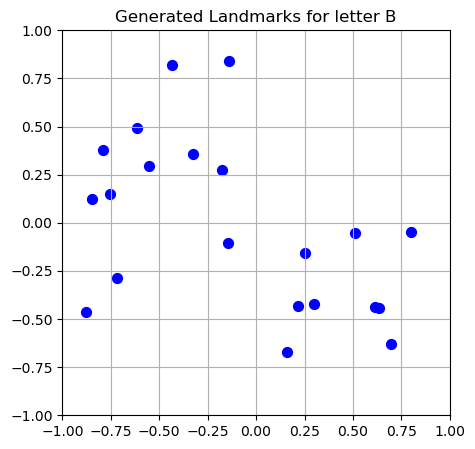

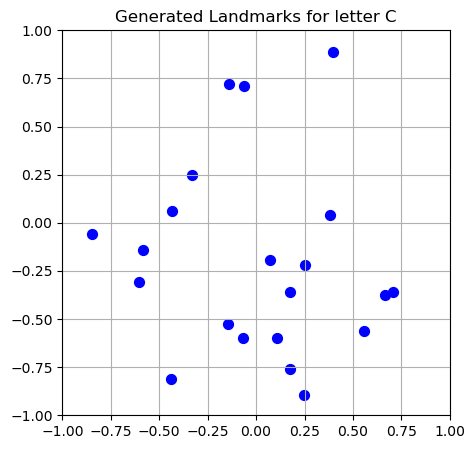

Epoch 160: 100%|██████████| 1/1 [00:00<00:00, 50.75it/s],  6.06it/s]



Epoch 161/200
Generator Loss: 4.2182
Discriminator Loss: 0.0141


Training Progress:  81%|████████  | 162/200 [00:20<00:05,  6.81it/s]


Epoch 162/200
Generator Loss: 4.2429
Discriminator Loss: 0.0148


Epoch 162: 100%|██████████| 1/1 [00:00<00:00, 35.83it/s]



Epoch 163/200
Generator Loss: 4.1755
Discriminator Loss: 0.0160


Epoch 163: 100%|██████████| 1/1 [00:00<00:00, 39.45it/s]



Epoch 164/200
Generator Loss: 4.0482
Discriminator Loss: 0.0151


Training Progress:  82%|████████▎ | 165/200 [00:20<00:03,  8.95it/s]


Epoch 165/200
Generator Loss: 3.8063
Discriminator Loss: 0.0324


Epoch 165: 100%|██████████| 1/1 [00:00<00:00, 35.88it/s]



Epoch 166/200
Generator Loss: 4.1854
Discriminator Loss: 0.0151


Epoch 166: 100%|██████████| 1/1 [00:00<00:00, 52.61it/s]



Epoch 167/200
Generator Loss: 4.1732
Discriminator Loss: 0.0180


Epoch 167: 100%|██████████| 1/1 [00:00<00:00, 49.21it/s]



Epoch 168/200
Generator Loss: 4.2060
Discriminator Loss: 0.0199


Training Progress:  84%|████████▍ | 169/200 [00:20<00:02, 11.51it/s]


Epoch 169/200
Generator Loss: 4.1556
Discriminator Loss: 0.0146


Epoch 169: 100%|██████████| 1/1 [00:00<00:00, 47.60it/s]



Epoch 170/200
Generator Loss: 4.0513
Discriminator Loss: 0.0186


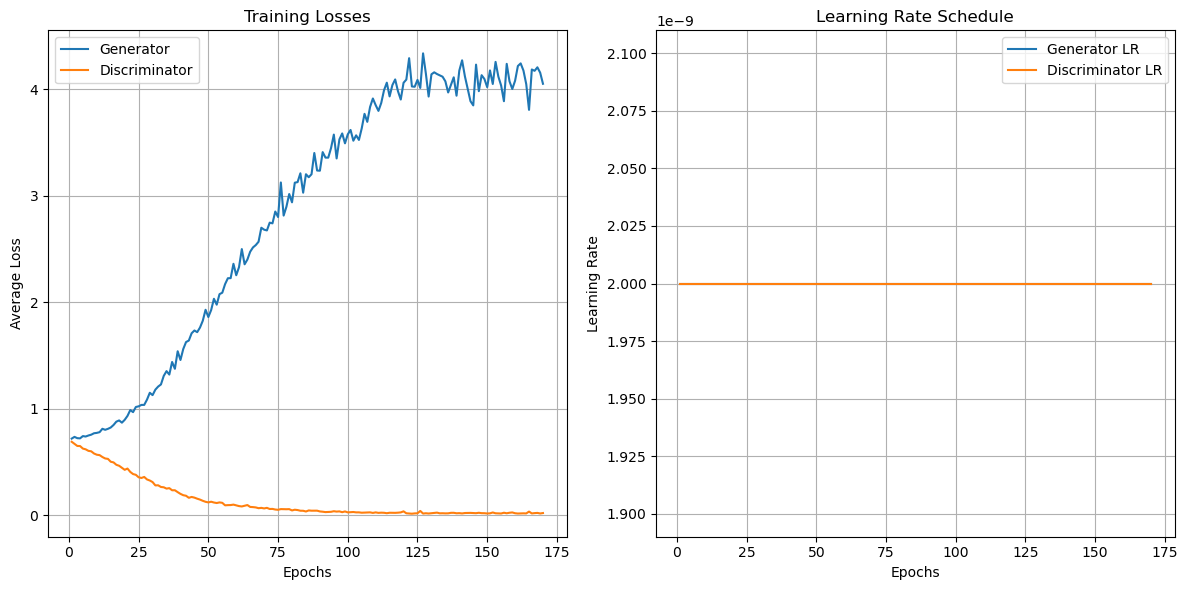

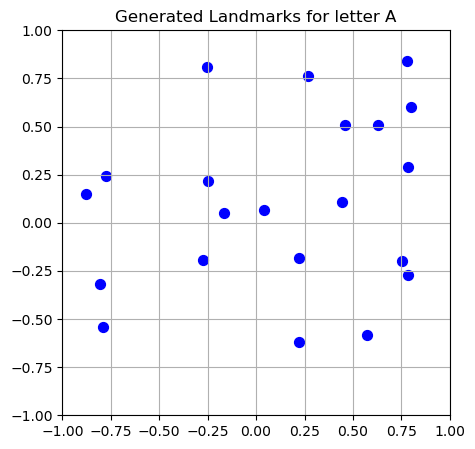

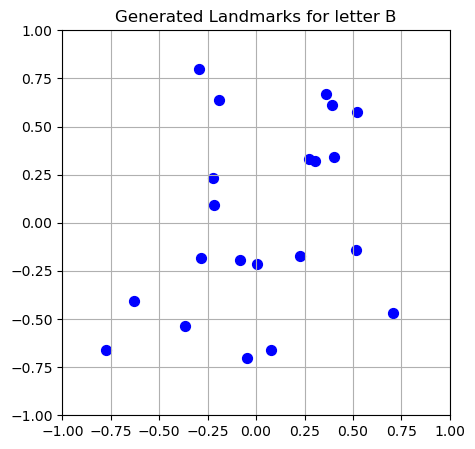

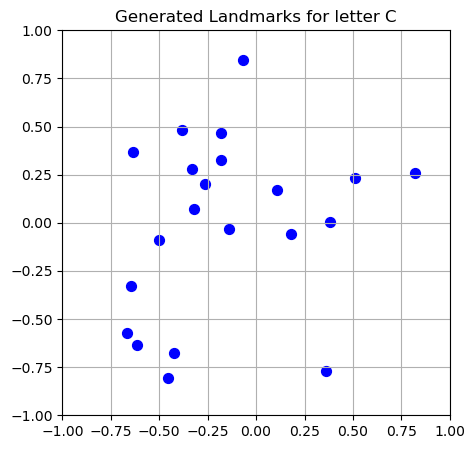

Training Progress:  86%|████████▌ | 171/200 [00:21<00:05,  5.79it/s]


Epoch 171/200
Generator Loss: 4.0512
Discriminator Loss: 0.0159


Epoch 171: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s]



Epoch 172/200
Generator Loss: 3.9258
Discriminator Loss: 0.0166


Epoch 172: 100%|██████████| 1/1 [00:00<00:00, 62.30it/s]



Epoch 173/200
Generator Loss: 4.0809
Discriminator Loss: 0.0163


Epoch 173: 100%|██████████| 1/1 [00:00<00:00, 57.09it/s]



Epoch 174/200
Generator Loss: 4.1049
Discriminator Loss: 0.0236


Epoch 174: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s]



Epoch 175/200
Generator Loss: 3.9463
Discriminator Loss: 0.0180


Training Progress:  88%|████████▊ | 176/200 [00:21<00:02,  9.21it/s]


Epoch 176/200
Generator Loss: 4.0507
Discriminator Loss: 0.0143


Epoch 176: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]



Epoch 177/200
Generator Loss: 3.9936
Discriminator Loss: 0.0203


Epoch 177: 100%|██████████| 1/1 [00:00<00:00, 51.75it/s]



Epoch 178/200
Generator Loss: 4.0749
Discriminator Loss: 0.0189


Training Progress:  90%|████████▉ | 179/200 [00:22<00:01, 10.60it/s]


Epoch 179/200
Generator Loss: 4.0797
Discriminator Loss: 0.0127


Epoch 179: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s]



Epoch 180/200
Generator Loss: 4.2195
Discriminator Loss: 0.0214


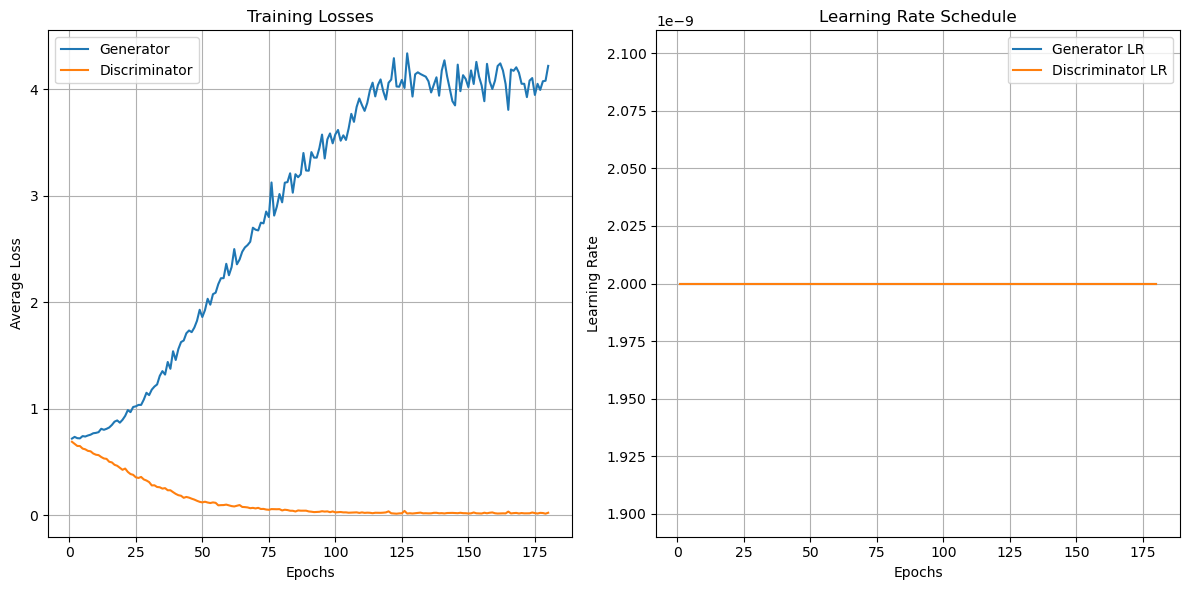

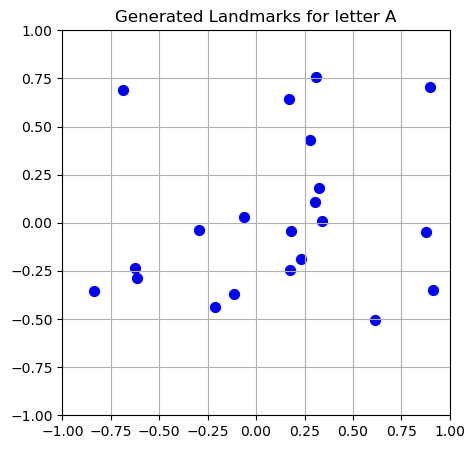

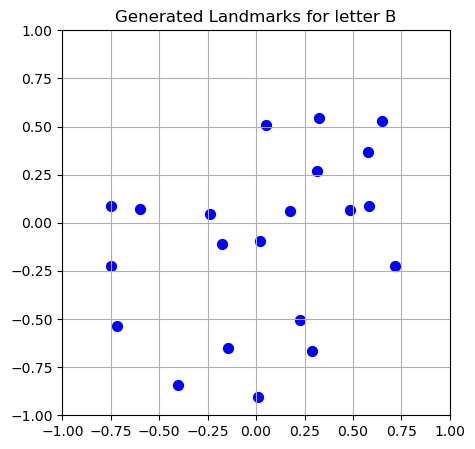

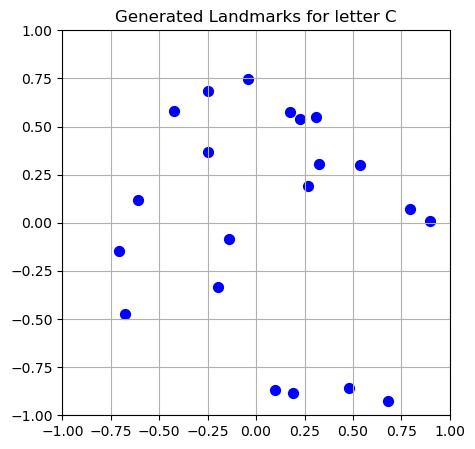

Epoch 180: 100%|██████████| 1/1 [00:00<00:00, 66.65it/s]



Epoch 181/200
Generator Loss: 4.0993
Discriminator Loss: 0.0168


Training Progress:  91%|█████████ | 182/200 [00:23<00:03,  5.84it/s]


Epoch 182/200
Generator Loss: 4.2323
Discriminator Loss: 0.0161


Epoch 182: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]



Epoch 183/200
Generator Loss: 4.0793
Discriminator Loss: 0.0238


Training Progress:  92%|█████████▏| 184/200 [00:23<00:02,  6.68it/s]


Epoch 184/200
Generator Loss: 3.9923
Discriminator Loss: 0.0178


Epoch 184: 100%|██████████| 1/1 [00:00<00:00, 51.18it/s]



Epoch 185/200
Generator Loss: 4.1036
Discriminator Loss: 0.0176


Epoch 185: 100%|██████████| 1/1 [00:00<00:00, 49.99it/s]



Epoch 186/200
Generator Loss: 4.2254
Discriminator Loss: 0.0238


Epoch 186: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s]



Epoch 187/200
Generator Loss: 3.9613
Discriminator Loss: 0.0189


Training Progress:  94%|█████████▍| 188/200 [00:23<00:01,  9.20it/s]


Epoch 188/200
Generator Loss: 4.0931
Discriminator Loss: 0.0184


Epoch 188: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]



Epoch 189/200
Generator Loss: 4.0651
Discriminator Loss: 0.0177


Epoch 189: 100%|██████████| 1/1 [00:00<00:00, 28.57it/s]



Epoch 190/200
Generator Loss: 4.0070
Discriminator Loss: 0.0146


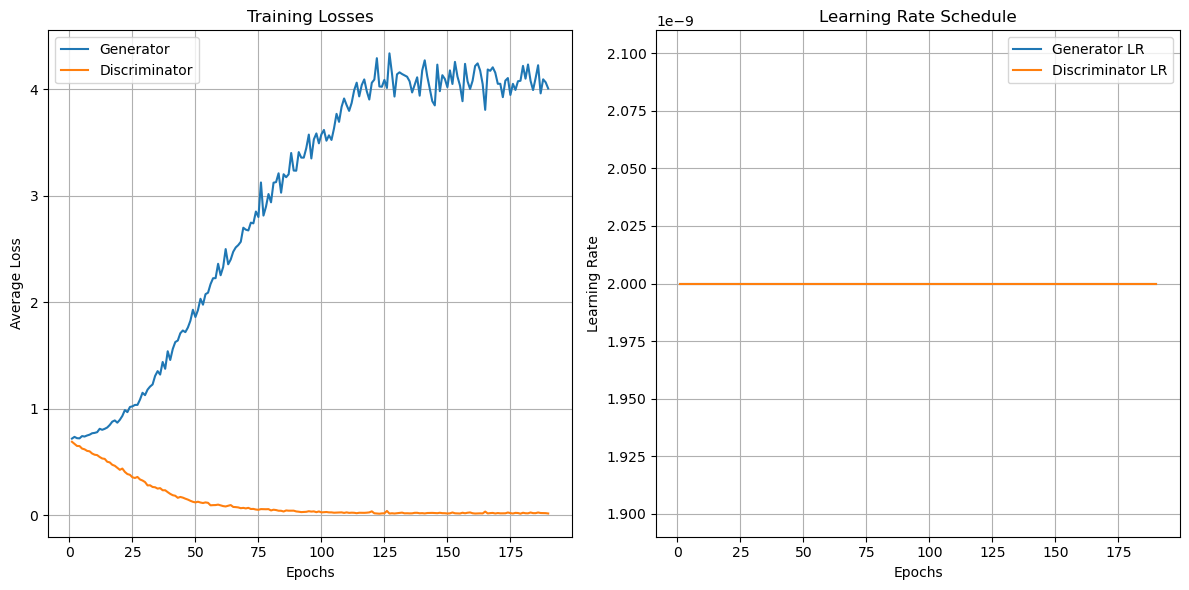

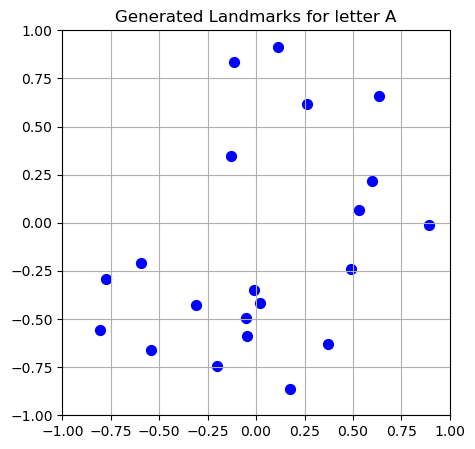

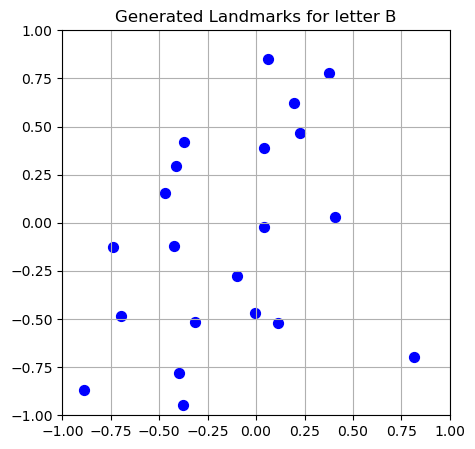

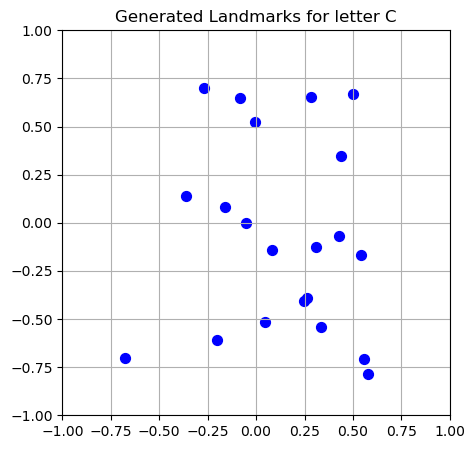

Epoch 190: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s],  5.03it/s]



Epoch 191/200
Generator Loss: 4.0120
Discriminator Loss: 0.0185


Epoch 191: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s]



Epoch 192/200
Generator Loss: 4.3235
Discriminator Loss: 0.0168


Epoch 192: 100%|██████████| 1/1 [00:00<00:00, 52.62it/s]



Epoch 193/200
Generator Loss: 4.2440
Discriminator Loss: 0.0154


Epoch 193: 100%|██████████| 1/1 [00:00<00:00, 48.72it/s]



Epoch 194/200
Generator Loss: 3.9436
Discriminator Loss: 0.0149


Training Progress:  98%|█████████▊| 195/200 [00:24<00:00,  7.94it/s]


Epoch 195/200
Generator Loss: 4.1165
Discriminator Loss: 0.0150


Epoch 195: 100%|██████████| 1/1 [00:00<00:00, 33.32it/s]



Epoch 196/200
Generator Loss: 4.0831
Discriminator Loss: 0.0171


Epoch 196: 100%|██████████| 1/1 [00:00<00:00, 48.75it/s]



Epoch 197/200
Generator Loss: 4.1347
Discriminator Loss: 0.0163


Epoch 197: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s]



Epoch 198/200
Generator Loss: 3.9360
Discriminator Loss: 0.0200


Training Progress: 100%|█████████▉| 199/200 [00:24<00:00, 10.66it/s]


Epoch 199/200
Generator Loss: 4.1280
Discriminator Loss: 0.0143


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 55.51it/s]



Epoch 200/200
Generator Loss: 4.0865
Discriminator Loss: 0.0180


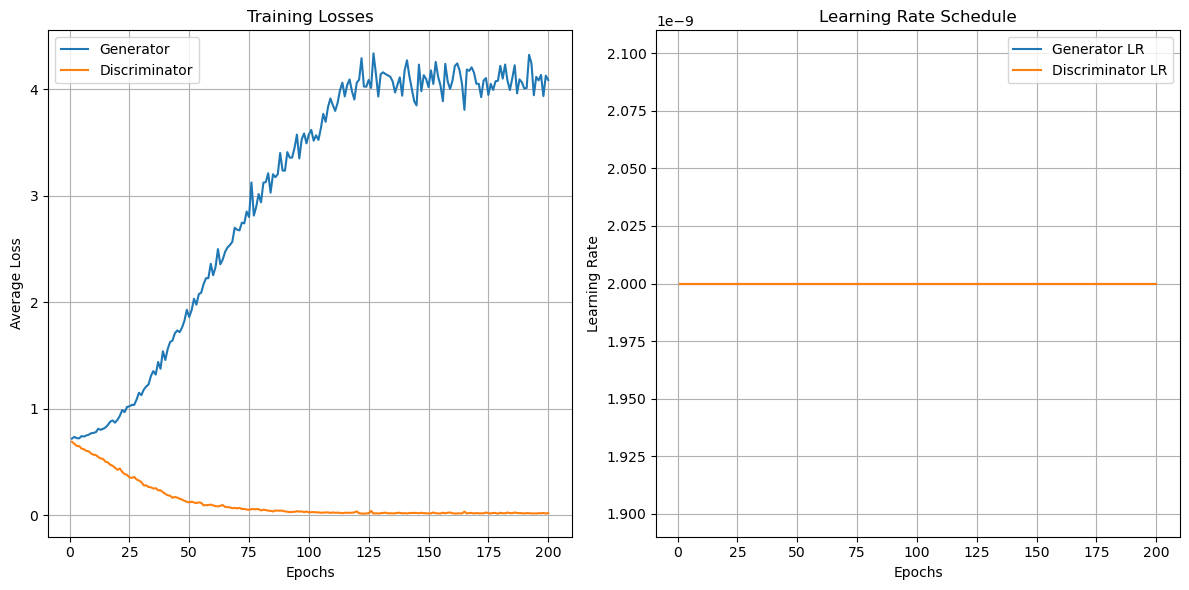

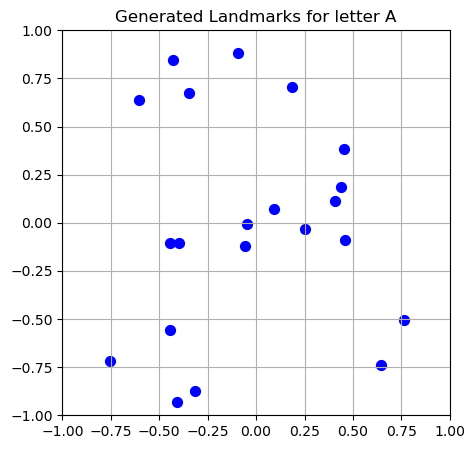

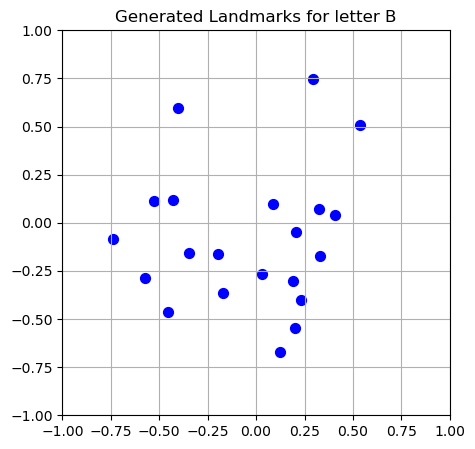

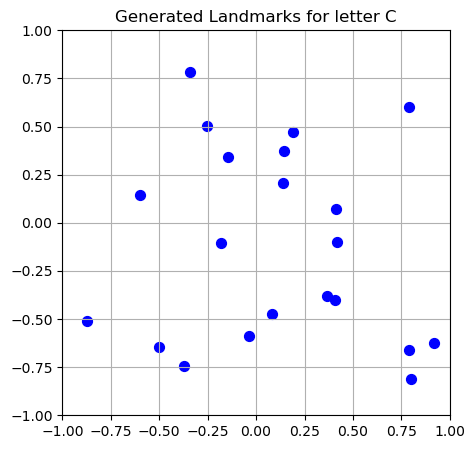

Training Progress: 100%|██████████| 200/200 [00:25<00:00,  7.71it/s]

Training completed!
Saving models...
Models saved to saved_models
Testing model...
Saving landmarks to text file...



C:\Users\HP\AppData\Local\Temp\ipykernel_5388\1891989175.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [10]:
import torch
import mediapipe as mp
import cv2
from pathlib import Path
import torch.cuda
from tqdm import tqdm

# Utility Functions
def generate_noise(batch_size, latent_dim=100):
    """Generate random noise vector for GAN"""
    return torch.randn(batch_size, latent_dim)


# 1. Add missing utility functions
def letter_to_onehot(letter):
    """Convert letter to one-hot encoding"""
    encoding = torch.zeros(26)
    encoding[ord(letter.lower()) - ord('a')] = 1
    return encoding

# 2. Define loss function
adversarial_loss = nn.BCELoss()

# def visualize_landmarks(landmarks):
#     """Visualize landmarks as points on a blank image"""
#     # Print the landmarks to understand their structure
#     print("Landmarks:", landmarks)

#     # Create a blank image
#     image = np.zeros((500, 500, 3), dtype=np.uint8)

#     # Draw the landmarks
#     for landmark in landmarks:
#         if isinstance(landmark, tuple) and len(landmark) == 2:
#             x, y = landmark
#             cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
#         else:
#             print(f"Unexpected landmark format: {landmark}")

#     return image
def visualize_landmarks(landmarks):
    # Create a blank image
    image = np.zeros((500, 500, 3), dtype=np.uint8)

    # Draw the landmarks
    for landmark in landmarks:
        if len(landmark) == 3:
            x, y, z = landmark
            # Scale coordinates to fit within the image
            x = int((x + 1) * 250)
            y = int((y + 1) * 250)
            # Use z to adjust the size of the circle
            radius = int((1 - z) * 10)  # Adjust the scaling factor as needed
            cv2.circle(image, (x, y), radius, (0, 255, 0), -1)
        else:
            print(f"Unexpected landmark format: {landmark}")

    return image

def get_dataloader(data_path, batch_size=32, shuffle=True):
    dataset = HandLandmarkDataset(data_path)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,  # Single process to avoid worker errors
        pin_memory=True if torch.cuda.is_available() else False
    )

def main():
    # Constants
    DATA_ROOT = './sample2'
    PREPROCESSED_DATA_PATH = './processed_data/landmarks.json'
    MODEL_SAVE_PATH = './saved_models'
    NUM_EPOCHS = 200
    BATCH_SIZE = 32
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    try:
        # Step 1: Preprocessing
        print("Step 1: Preprocessing...")
        preprocessor = LandmarkPreprocessor(
            data_root=DATA_ROOT, 
            save_path=Path('./processed_data')
        )
        Path('./processed_data').mkdir(parents=True, exist_ok=True)
        
        if not Path(PREPROCESSED_DATA_PATH).exists():
            preprocessor.process_dataset()
        else:
            print(f"Using existing preprocessed data from {PREPROCESSED_DATA_PATH}")

        # Step 2: Data Loading
        print("Step 2: Preparing DataLoader...")
        train_loader = get_dataloader(
            PREPROCESSED_DATA_PATH,
            batch_size=BATCH_SIZE,
            shuffle=True
        )

        # Step 3: Model Initialization
        print("Step 3: Initializing models...")
        generator = Generator().to(DEVICE)
        discriminator = Discriminator().to(DEVICE)

        # Step 4: Training
        print("Step 4: Training GAN...")
        trainer = GANTrainer(
            generator=generator,
            discriminator=discriminator,
            device=DEVICE
        )

        trainer.train(train_loader, num_epochs=NUM_EPOCHS)

        # Step 5: Save Models
        print("Saving models...")
        save_path = Path(MODEL_SAVE_PATH)
        save_path.mkdir(parents=True, exist_ok=True)
        
        torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict()
        }, save_path / 'gan_model.pth')
        print(f"Models saved to {save_path}")

        # Step 6: Testing
        print("Testing model...")
        tester = ModelTester(
            model_path=save_path / 'gan_model.pth',
            device=DEVICE
        )
        
        test_letters = ['A', 'B', 'C', 'D']
        test_results = tester.evaluate_generation(letters=test_letters)

        # ----------------------------------------------------------------------------
        # # Step 7: Visualization
        # print("Displaying results...")
        # for letter, result in test_results.items():
        #     print(f"Showing landmarks for letter: {letter}")
        #     cv2.imshow(f"Letter {letter}", result['visualization'])
        #     cv2.waitKey(0)
        
        # cv2.destroyAllWindows()
        # ----------------------------------------------------------------------------
# Step 7: Save landmarks to a text file
        print("Saving landmarks to text file...")
        with open("landmarks.txt", "w") as file:
            for letter, landmarks in test_results.items():
                file.write(f"Letter {letter}:\n")
                for landmark in landmarks:
                    file.write(f"{landmark}\n")
                file.write("\n")
        # ----------------------------------------------------------------------------



    except FileNotFoundError as e:
        print(f"File not found error: {str(e)}")
        raise
    except RuntimeError as e:
        print(f"Runtime error (possibly CUDA): {str(e)}")
        raise
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        raise
    finally:
        cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

In [39]:
# Test the functions
test_letter = 'A'
one_hot = letter_to_onehot(test_letter)
print(f"One-hot encoding for {test_letter}:", one_hot)

# Create dataloader
train_loader = get_dataloader('processed_data/landmarks.json')

One-hot encoding for A: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
